# 金融计算 & 量化投资 课程实验部分代码

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

from src.calc.factor_models import estimate_capm, estimate_fama_french
from src.calc.calculate_beta import calculate_beta
from src.tools.factor_data_api import get_market_returns, get_risk_free_rate, get_fama_french_factors
from src.tools.api import get_price_data
from src.calc.covariance_estimation import estimate_covariance_ewma
from src.calc.portfolio_optimization import optimize_portfolio, efficient_frontier
from model.deap_factors import FactorAgent
from model.dl import MLAgent, preprocess_stock_data
from model.rl import RLTradingAgent
from src.calc.volatility_models import fit_garch, forecast_garch_volatility, calculate_realized_volatility
from src.calc.tail_risk_measures import calculate_historical_var, calculate_conditional_var, calculate_parametric_var, backtesting_var
from src.backtester import Backtester
from src.main import run_hedge_fund
import uuid

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False 

2025-05-06 15:30:42 - api_calls - INFO - ✓ 已加载环境变量: c:\users\15170\desktop\stock_agent\.env
2025-05-06 15:30:42 - api_calls - INFO - ✓ OpenAI Compatible 客户端初始化成功


✓ 已成功修补所有代理类的JSON序列化方法
日志记录器已初始化，日志文件: logs/output_20250506_153042.txt
运行环境: Jupyter Notebook


In [2]:
print('aaa')

## 第一部分：资产定价模型验证

我们首先验证CAPM和Fama-French三因子模型在中国A股市场的适用性。

### 1.1 数据准备

INFO:root:Getting price history for 600519 from 2023-01-01 to 2023-12-31
INFO:src.tools.data_source_adapter.cache:Using cached data for price_hist_600519_20230101_20231231_qfq
INFO:root:Successfully retrieved 242 records from cache
2025-05-06 15:12:34 - api - INFO - Successfully processed price data (242 records)
2025-05-06 15:12:34,691 - factor_data_api - INFO - 获取市场收益率数据: 2023-01-01 至 2023-12-31, 指数代码: 000300, 频率: D
INFO:factor_data_api:获取市场收益率数据: 2023-01-01 至 2023-12-31, 指数代码: 000300, 频率: D
2025-05-06 15:12:34,885 - factor_data_api - INFO - 成功使用TuShare获取市场收益率数据: 241 条记录
INFO:factor_data_api:成功使用TuShare获取市场收益率数据: 241 条记录
INFO:calculate_beta:股票日期范围: 2023-01-04 00:00:00 到 2023-12-29 00:00:00
INFO:calculate_beta:市场日期范围: 2023-01-04 00:00:00 到 2023-12-29 00:00:00
INFO:calculate_beta:共同日期数量: 241
INFO:calculate_beta:成功计算 600519 的Beta值: 1.04
INFO:root:Getting price history for 000858 from 2023-01-01 to 2023-12-31
INFO:src.tools.data_source_adapter.cache:Using cached data for price_hist_00085

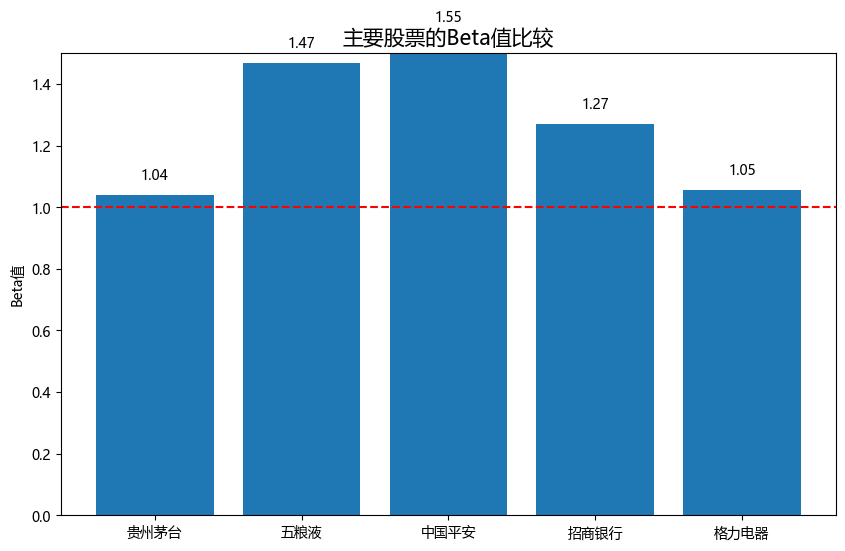

In [10]:
# 测试股票样本
test_stocks = ['600519', '000858', '601318', '600036', '000651']
stock_names = ['贵州茅台', '五粮液', '中国平安', '招商银行', '格力电器']
start_date = '2023-01-01'
end_date = '2023-12-31'

# 计算每只股票的Beta值
beta_values = {}
for stock in test_stocks:
    try:
        beta = calculate_beta(stock, market_index="000300", start_date=start_date, end_date=end_date)
        beta_values[stock] = beta
        print(f"{stock} Beta值: {beta:.4f}")
    except Exception as e:
        print(f"计算{stock}的Beta值时出错: {str(e)}")
        beta_values[stock] = np.nan

# 可视化Beta值
plt.figure(figsize=(10, 6))
plt.bar(stock_names, [beta_values.get(stock, np.nan) for stock in test_stocks])
plt.axhline(y=1.0, color='r', linestyle='--')
plt.title('主要股票的Beta值比较', fontsize=15)
plt.ylabel('Beta值')
plt.ylim(0, 1.5)

for i, stock in enumerate(test_stocks):
    v = beta_values.get(stock, np.nan)
    if not np.isnan(v):
        plt.text(i, v + 0.05, f"{v:.2f}", ha='center')

 
plt.show()

### 1.2 CAPM模型分析

INFO:root:Getting price history for 600519 from 2023-01-01 to 2023-12-31
INFO:src.tools.data_source_adapter.cache:Using cached data for price_hist_600519_20230101_20231231_qfq
INFO:root:Successfully retrieved 242 records from cache
2025-05-06 15:12:15 - api - INFO - Successfully processed price data (242 records)
2025-05-06 15:12:15,230 - factor_data_api - INFO - 获取市场收益率数据: 2023-01-01 至 2023-12-31, 指数代码: 000300, 频率: D
INFO:factor_data_api:获取市场收益率数据: 2023-01-01 至 2023-12-31, 指数代码: 000300, 频率: D
2025-05-06 15:12:15,364 - factor_data_api - INFO - 成功使用TuShare获取市场收益率数据: 241 条记录
INFO:factor_data_api:成功使用TuShare获取市场收益率数据: 241 条记录
2025-05-06 15:12:15,367 - factor_data_api - INFO - 获取无风险利率数据: 2023-01-01 至 2023-12-31, 频率: D
INFO:factor_data_api:获取无风险利率数据: 2023-01-01 至 2023-12-31, 频率: D
2025-05-06 15:12:15,372 - factor_data_api - INFO - 成功从缓存加载无风险利率数据: 21 条记录
INFO:factor_data_api:成功从缓存加载无风险利率数据: 21 条记录


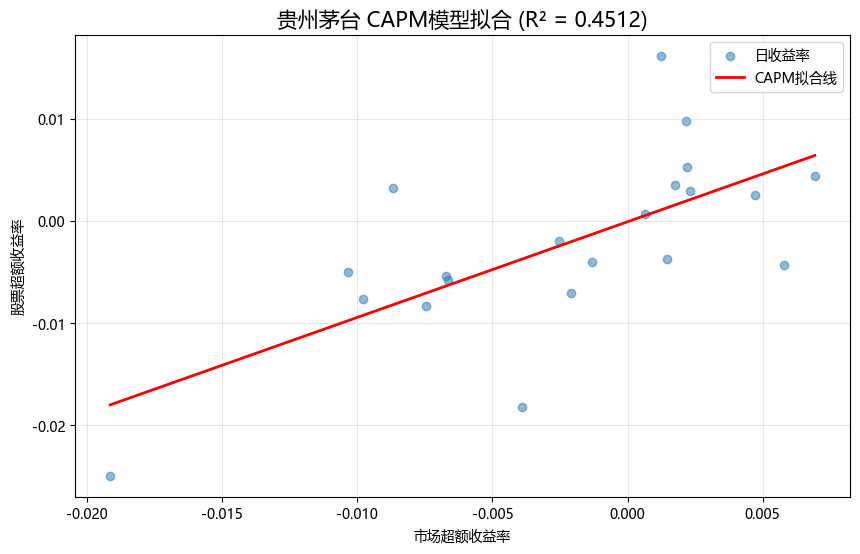

INFO:root:Getting price history for 000858 from 2023-01-01 to 2023-12-31
INFO:src.tools.data_source_adapter.cache:Using cached data for price_hist_000858_20230101_20231231_qfq
INFO:root:Successfully retrieved 242 records from cache
2025-05-06 15:12:15 - api - INFO - Successfully processed price data (242 records)
2025-05-06 15:12:15,534 - factor_data_api - INFO - 获取市场收益率数据: 2023-01-01 至 2023-12-31, 指数代码: 000300, 频率: D
INFO:factor_data_api:获取市场收益率数据: 2023-01-01 至 2023-12-31, 指数代码: 000300, 频率: D
2025-05-06 15:12:15,661 - factor_data_api - INFO - 成功使用TuShare获取市场收益率数据: 241 条记录
INFO:factor_data_api:成功使用TuShare获取市场收益率数据: 241 条记录
2025-05-06 15:12:15,663 - factor_data_api - INFO - 获取无风险利率数据: 2023-01-01 至 2023-12-31, 频率: D
INFO:factor_data_api:获取无风险利率数据: 2023-01-01 至 2023-12-31, 频率: D
2025-05-06 15:12:15,667 - factor_data_api - INFO - 成功从缓存加载无风险利率数据: 21 条记录
INFO:factor_data_api:成功从缓存加载无风险利率数据: 21 条记录


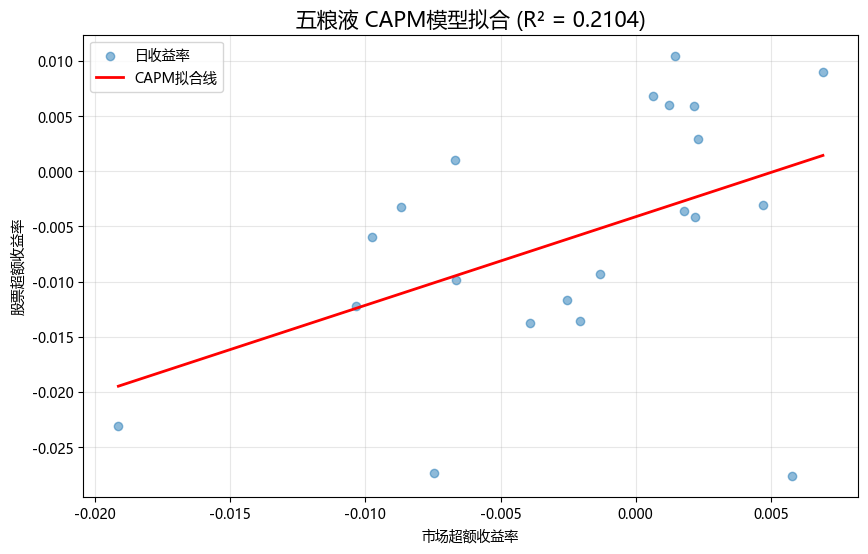

INFO:root:Getting price history for 601318 from 2023-01-01 to 2023-12-31
INFO:src.tools.data_source_adapter.cache:Using cached data for price_hist_601318_20230101_20231231_qfq
INFO:root:Successfully retrieved 242 records from cache
2025-05-06 15:12:15 - api - INFO - Successfully processed price data (242 records)
2025-05-06 15:12:15,841 - factor_data_api - INFO - 获取市场收益率数据: 2023-01-01 至 2023-12-31, 指数代码: 000300, 频率: D
INFO:factor_data_api:获取市场收益率数据: 2023-01-01 至 2023-12-31, 指数代码: 000300, 频率: D


In [ ]:
def perform_capm_analysis(stock_code, start_date, end_date):
    """执行CAPM模型分析"""
    # 获取数据
    stock_data = get_price_data(stock_code, start_date, end_date)
    market_ret = get_market_returns(index_code="000300", start_date=start_date, end_date=end_date)
    risk_free = get_risk_free_rate(start_date=start_date, end_date=end_date)
    
    if stock_data is None or market_ret is None or risk_free is None:
        print(f"无法获取{stock_code}的完整数据，跳过CAPM分析")
        return None, None, None, None
    
    # 计算股票收益率
    stock_data['return'] = stock_data['close'].pct_change().fillna(0)
    stock_returns = pd.Series(stock_data['return'].values, index=stock_data['date'])
    
    # 对齐数据
    common_dates = stock_returns.index.intersection(market_ret.index).intersection(risk_free.index)
    stock_returns = stock_returns.loc[common_dates]
    market_ret = market_ret.loc[common_dates]
    risk_free = risk_free.loc[common_dates]
    
    # 估计CAPM模型
    capm_results = estimate_capm(stock_returns, market_ret, risk_free)
    
    return capm_results, stock_returns, market_ret, risk_free

# 分析每只股票
capm_results_all = {}
for i, stock in enumerate(test_stocks):
    try:
        result, stock_ret, market_ret, risk_free = perform_capm_analysis(stock, start_date, end_date)
        if result is not None:
            capm_results_all[stock] = result
            
            # 打印结果
            print(f"\n{stock_names[i]} ({stock}) CAPM分析结果:")
            print(f"Alpha: {result['alpha']:.6f}")
            print(f"Beta: {result['beta']:.4f}")
            print(f"R²: {result['r_squared']:.4f}")
            print(f"信息比率: {result['information_ratio']:.4f}")
            print(f"P值(Alpha): {result['p_value_alpha']:.4f}")
            print(f"P值(Beta): {result['p_value_beta']:.4f}")
            
            # 可视化CAPM拟合
            plt.figure(figsize=(10, 6))
            
            # 计算超额收益率
            excess_returns = stock_ret - risk_free
            excess_market = market_ret - risk_free
            
            # 散点图
            plt.scatter(excess_market, excess_returns, alpha=0.5, label='日收益率')
            
            # 添加CAPM拟合线
            x_range = np.linspace(min(excess_market), max(excess_market), 100)
            y_pred = result['alpha'] + result['beta'] * x_range
            plt.plot(x_range, y_pred, 'r', linewidth=2, label='CAPM拟合线')
            
            plt.title(f'{stock_names[i]} CAPM模型拟合 (R² = {result["r_squared"]:.4f})', fontsize=15)
            plt.xlabel('市场超额收益率')
            plt.ylabel('股票超额收益率')
            plt.grid(True, alpha=0.3)
            plt.legend()
            
             
            plt.show()
    except Exception as e:
        print(f"分析{stock}时出错: {str(e)}")

### 1.3 CAPM参数显著性检验

In [ ]:
def analyze_capm_significance(capm_results):
    """分析CAPM模型参数的统计显著性"""
    alpha_significant = []
    beta_significant = []
    
    for stock, result in capm_results.items():
        # Alpha显著性检验 (p < 0.05)
        alpha_sig = result['p_value_alpha'] < 0.05
        alpha_significant.append(alpha_sig)
        
        # Beta显著性检验 (p < 0.05)
        beta_sig = result['p_value_beta'] < 0.05
        beta_significant.append(beta_sig)
        
        print(f"股票 {stock}:")
        print(f"  Alpha = {result['alpha']:.6f}, p值 = {result['p_value_alpha']:.4f}, 显著性: {'显著' if alpha_sig else '不显著'}")
        print(f"  Beta = {result['beta']:.4f}, p值 = {result['p_value_beta']:.4f}, 显著性: {'显著' if beta_sig else '不显著'}")
    
    # 计算显著性比例
    alpha_sig_ratio = sum(alpha_significant) / len(alpha_significant) if alpha_significant else 0
    beta_sig_ratio = sum(beta_significant) / len(beta_significant) if beta_significant else 0
    
    print(f"\nAlpha显著性比例: {alpha_sig_ratio:.2f} ({sum(alpha_significant)}/{len(alpha_significant)})")
    print(f"Beta显著性比例: {beta_sig_ratio:.2f} ({sum(beta_significant)}/{len(beta_significant)})")
    
    return {
        'alpha_significant': alpha_significant,
        'beta_significant': beta_significant,
        'alpha_sig_ratio': alpha_sig_ratio,
        'beta_sig_ratio': beta_sig_ratio
    }

# 分析CAPM参数显著性
capm_significance = analyze_capm_significance(capm_results_all)

### 1.4 Fama-French三因子模型分析

In [ ]:
def perform_ff_analysis(stock_code, start_date, end_date):
    """执行Fama-French三因子模型分析"""
    # 获取数据
    stock_data = get_price_data(stock_code, start_date, end_date)
    ff_factors = get_fama_french_factors(start_date=start_date, end_date=end_date)
    
    if stock_data is None or ff_factors is None:
        print(f"无法获取{stock_code}的完整数据，跳过FF分析")
        return None, None, None, None, None, None
    
    # 计算股票收益率
    stock_data['return'] = stock_data['close'].pct_change().fillna(0)
    stock_returns = pd.Series(stock_data['return'].values, index=stock_data['date'])
    
    # 对齐数据
    market_ret = ff_factors['market_returns']
    smb = ff_factors['smb']
    hml = ff_factors['hml']
    risk_free = ff_factors['risk_free_rate']
    
    common_dates = stock_returns.index.intersection(market_ret.index).intersection(smb.index).intersection(hml.index)
    stock_returns = stock_returns.loc[common_dates]
    market_ret = market_ret.loc[common_dates]
    smb = smb.loc[common_dates]
    hml = hml.loc[common_dates]
    risk_free = risk_free.loc[common_dates]
    
    # 估计Fama-French三因子模型
    ff_results = estimate_fama_french(stock_returns, market_ret, smb, hml, risk_free)
    
    return ff_results, stock_returns, market_ret, smb, hml, risk_free

# 分析每只股票的Fama-French三因子模型
ff_results_all = {}
for i, stock in enumerate(test_stocks):
    try:
        result, stock_ret, market_ret, smb, hml, risk_free = perform_ff_analysis(stock, start_date, end_date)
        if result is not None:
            ff_results_all[stock] = result
            
            # 打印结果
            print(f"\n{stock_names[i]} ({stock}) Fama-French三因子分析结果:")
            print(f"Alpha: {result['alpha']:.6f}")
            print(f"市场Beta: {result['beta_market']:.4f}")
            print(f"SMB系数: {result['beta_smb']:.4f}")
            print(f"HML系数: {result['beta_hml']:.4f}")
            print(f"R²: {result['r_squared']:.4f}")
            print(f"年化Alpha: {result['annualized_alpha']:.4f}")
            print(f"P值(Alpha): {result.get('p_value_alpha', 'N/A')}")
            print(f"P值(Beta市场): {result.get('p_value_market', 'N/A')}")
            print(f"P值(Beta SMB): {result.get('p_value_smb', 'N/A')}")
            print(f"P值(Beta HML): {result.get('p_value_hml', 'N/A')}")
    except Exception as e:
        print(f"分析{stock}时出错: {str(e)}")

INFO:root:Getting price history for 600519 from 2023-01-01 to 2023-12-31
INFO:src.tools.data_source_adapter.cache:Using cached data for price_hist_600519_20230101_20231231_qfq
INFO:root:Successfully retrieved 242 records from cache
2025-05-06 12:31:43 - api - INFO - Successfully processed price data (242 records)
2025-05-06 12:31:43,096 - factor_data_api - INFO - 获取Fama-French三因子数据: 2023-01-01 至 2023-12-31, 频率: D
INFO:factor_data_api:获取Fama-French三因子数据: 2023-01-01 至 2023-12-31, 频率: D
2025-05-06 12:31:43,101 - factor_data_api - INFO - 成功从缓存加载Fama-French因子数据: 241 条记录
INFO:factor_data_api:成功从缓存加载Fama-French因子数据: 241 条记录
INFO:root:Getting price history for 000858 from 2023-01-01 to 2023-12-31
INFO:src.tools.data_source_adapter.cache:Using cached data for price_hist_000858_20230101_20231231_qfq
INFO:root:Successfully retrieved 242 records from cache
2025-05-06 12:31:43 - api - INFO - Successfully processed price data (242 records)
2025-05-06 12:31:43,130 - factor_data_api - INFO - 获取Fama-Fr

### 1.5 模型比较与统计检验

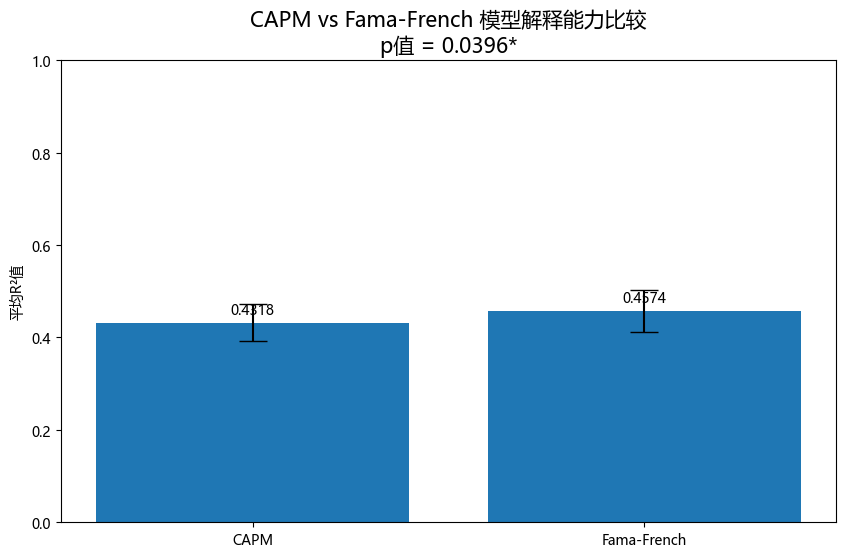

In [ ]:
def compare_models_statistically(capm_results, ff_results):
    """使用统计检验比较CAPM和Fama-French模型"""
    # 配对样本的R²值
    capm_r2 = []
    ff_r2 = []
    
    common_stocks = set(capm_results.keys()).intersection(set(ff_results.keys()))
    
    for stock in common_stocks:
        capm_r2.append(capm_results[stock]['r_squared'])
        ff_r2.append(ff_results[stock]['r_squared'])
    
    if len(capm_r2) < 2:
        print("样本数量不足，无法进行模型比较统计检验")
        return None
    
    # 配对样本t检验 (检验FF模型是否显著优于CAPM)
    t_stat, p_value = stats.ttest_rel(ff_r2, capm_r2)
    
    print("\nCAPM与Fama-French模型R²比较:")
    print(f"CAPM平均R²: {np.mean(capm_r2):.4f}")
    print(f"FF平均R²: {np.mean(ff_r2):.4f}")
    print(f"R²提升: {np.mean(ff_r2) - np.mean(capm_r2):.4f}")
    print(f"t统计量: {t_stat:.4f}")
    print(f"p值: {p_value:.4f}")
    print(f"结论: {'FF模型显著优于CAPM模型' if p_value < 0.05 and t_stat > 0 else 'FF模型未显著优于CAPM模型'}")
    
    # 可视化比较
    plt.figure(figsize=(10, 6))
    plt.bar(['CAPM', 'Fama-French'], [np.mean(capm_r2), np.mean(ff_r2)], 
            yerr=[np.std(capm_r2)/np.sqrt(len(capm_r2)), np.std(ff_r2)/np.sqrt(len(ff_r2))],
            capsize=10)
    plt.title('CAPM vs Fama-French 模型解释能力比较\n'
              f'p值 = {p_value:.4f}{"*" if p_value < 0.05 else " (不显著)"}', fontsize=15)
    plt.ylabel('平均R²值')
    plt.ylim(0, 1)
    
    # 添加数值标签
    plt.text(0, np.mean(capm_r2) + 0.02, f"{np.mean(capm_r2):.4f}", ha='center')
    plt.text(1, np.mean(ff_r2) + 0.02, f"{np.mean(ff_r2):.4f}", ha='center')
    
     
    plt.show()
    
    return {
        'capm_r2': capm_r2,
        'ff_r2': ff_r2,
        't_stat': t_stat,
        'p_value': p_value,
        'significant': p_value < 0.05 and t_stat > 0
    }

# 比较CAPM和FF模型
model_comparison = compare_models_statistically(capm_results_all, ff_results_all)

## 第二部分：资产配置与投资组合优化

本部分我们使用现代投资组合理论构建优化投资组合。

### 2.1 基于遗传编程的因子挖掘

In [ ]:
def evaluate_factor_performance(price_data, factor_values, plot=True):
    """评估因子表现"""
    # 合并数据
    df = price_data.copy()
    
    # 添加因子值
    for factor_name, values in factor_values.items():
        if len(values) == len(df):
            df[factor_name] = values
    
    # 计算每个因子的IC值
    ic_values = {}
    for factor_name in factor_values.keys():
        # 计算每个因子与未来收益的相关性
        future_return = df['close'].pct_change(5).shift(-5)  # 5日未来收益
        ic = df[factor_name].corr(future_return)
        ic_values[factor_name] = ic
    
    if plot and len(ic_values) > 0:
        # 可视化IC值
        plt.figure(figsize=(10, 6))
        plt.bar(ic_values.keys(), ic_values.values())
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('因子IC值比较', fontsize=15)
        plt.ylabel('信息系数(IC)')
        plt.xticks(rotation=45)
        
        for i, (k, v) in enumerate(ic_values.items()):
            plt.text(i, v + 0.01 if v > 0 else v - 0.03, f"{v:.3f}", ha='center')
        
        plt.show()
    
    return ic_values

def test_factor_significance(price_data, factor_values):
    """测试因子的统计显著性"""
    # 计算未来收益率
    future_return = price_data['close'].pct_change(5).shift(-5).dropna()
    
    # 创建数据框
    data = pd.DataFrame({'future_return': future_return})
    
    # 添加因子，确保长度匹配
    for factor_name, values in factor_values.items():
        if len(values) >= len(future_return):
            # 裁剪因子长度与未来收益率匹配
            data[factor_name] = values[:len(future_return)]
    
    # 无效数据处理
    data = data.dropna()
    
    if len(data.columns) <= 1 or len(data) < 10:
        print("有效数据不足，无法进行因子显著性测试")
        return None
    
    # 进行多元回归分析
    # 添加常数项
    X = sm.add_constant(data.drop('future_return', axis=1))
    y = data['future_return']
    
    # 拟合模型
    model = sm.OLS(y, X).fit()
    
    # 输出结果
    print(model.summary())
    
    # 提取关键信息
    factor_results = {
        'R-squared': model.rsquared,
        'Adj. R-squared': model.rsquared_adj,
        'F-statistic': model.fvalue,
        'Prob (F-statistic)': model.f_pvalue,
    }
    
    # 提取各因子的系数和p值
    factor_coefficients = []
    for name, coef, pval in zip(model.params.index[1:], model.params[1:], model.pvalues[1:]):
        factor_coefficients.append({
            'factor': name,
            'coefficient': coef,
            'p_value': pval,
            'significant': pval < 0.05
        })
    
    # 可视化因子系数及显著性
    plt.figure(figsize=(12, 6))
    
    factors = [f['factor'] for f in factor_coefficients]
    coefs = [f['coefficient'] for f in factor_coefficients]
    pvals = [f['p_value'] for f in factor_coefficients]
    
    # 设置颜色 (显著性)
    colors = ['green' if p < 0.05 else 'red' for p in pvals]
    
    plt.bar(factors, coefs, color=colors)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    plt.title('因子系数及统计显著性 (* p<0.05)', fontsize=15)
    plt.ylabel('系数值')
    plt.xticks(rotation=45)
    
    # 添加显著性标记和系数值
    for i, (coef, pval) in enumerate(zip(coefs, pvals)):
        plt.text(i, coef + (0.01 if coef >= 0 else -0.01), 
                f"{coef:.4f}{' *' if pval < 0.05 else ''}", 
                ha='center', va='bottom' if coef >= 0 else 'top')
    
     
    plt.show()
    
    # 创建因子显著性汇总表
    sig_table = pd.DataFrame(factor_coefficients)
    print("\n因子显著性汇总:")
    print(sig_table)
    
    # 显著因子比例
    sig_ratio = sum(f['significant'] for f in factor_coefficients) / len(factor_coefficients)
    print(f"\n显著因子比例: {sig_ratio:.2f} ({sum(f['significant'] for f in factor_coefficients)}/{len(factor_coefficients)})")
    
    return {
        'model_stats': factor_results,
        'factor_coefficients': factor_coefficients,
        'significant_ratio': sig_ratio
    }

INFO:root:Getting price history for 600519 from 2022-01-01 to 2023-12-31
INFO:src.tools.data_source_adapter.cache:Using cached data for price_hist_600519_20220101_20231231_qfq
INFO:root:Successfully retrieved 484 records from cache
2025-05-06 12:31:43 - api - INFO - Successfully processed price data (484 records)
INFO:factor_mining:开始因子进化，种群大小: 50，迭代次数: 20
INFO:factor_mining:因子 GP_Factor_1 生成完成，适应度: 0.2307
INFO:factor_mining:因子 GP_Factor_2 生成完成，适应度: 0.2057
INFO:factor_mining:因子 GP_Factor_3 生成完成，适应度: 0.1807
INFO:factor_mining:因子 GP_Factor_4 生成完成，适应度: 0.1578
INFO:factor_mining:已将4个因子保存至 factors\best_factors.json


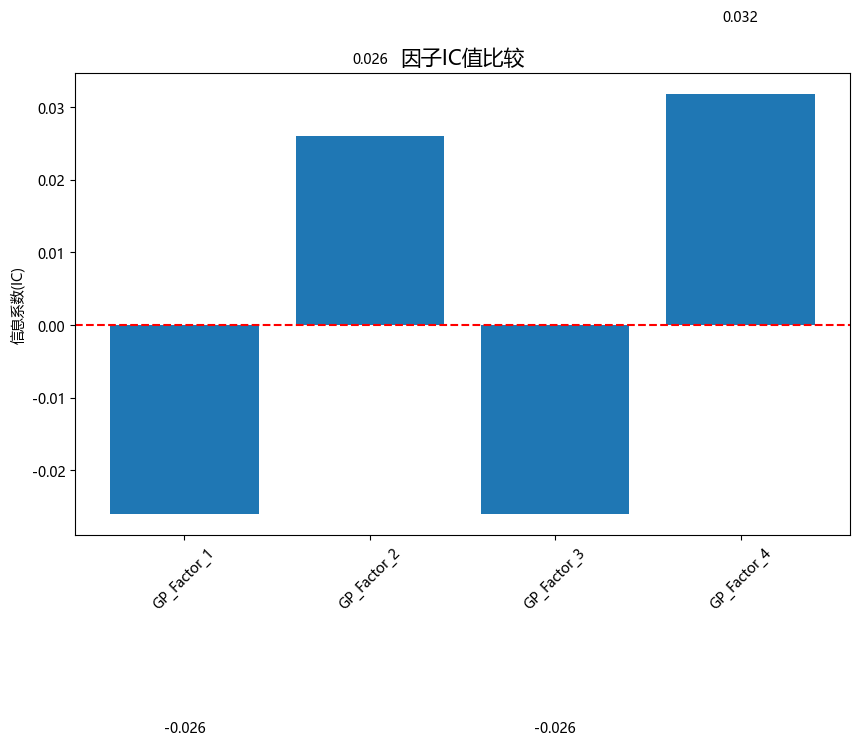

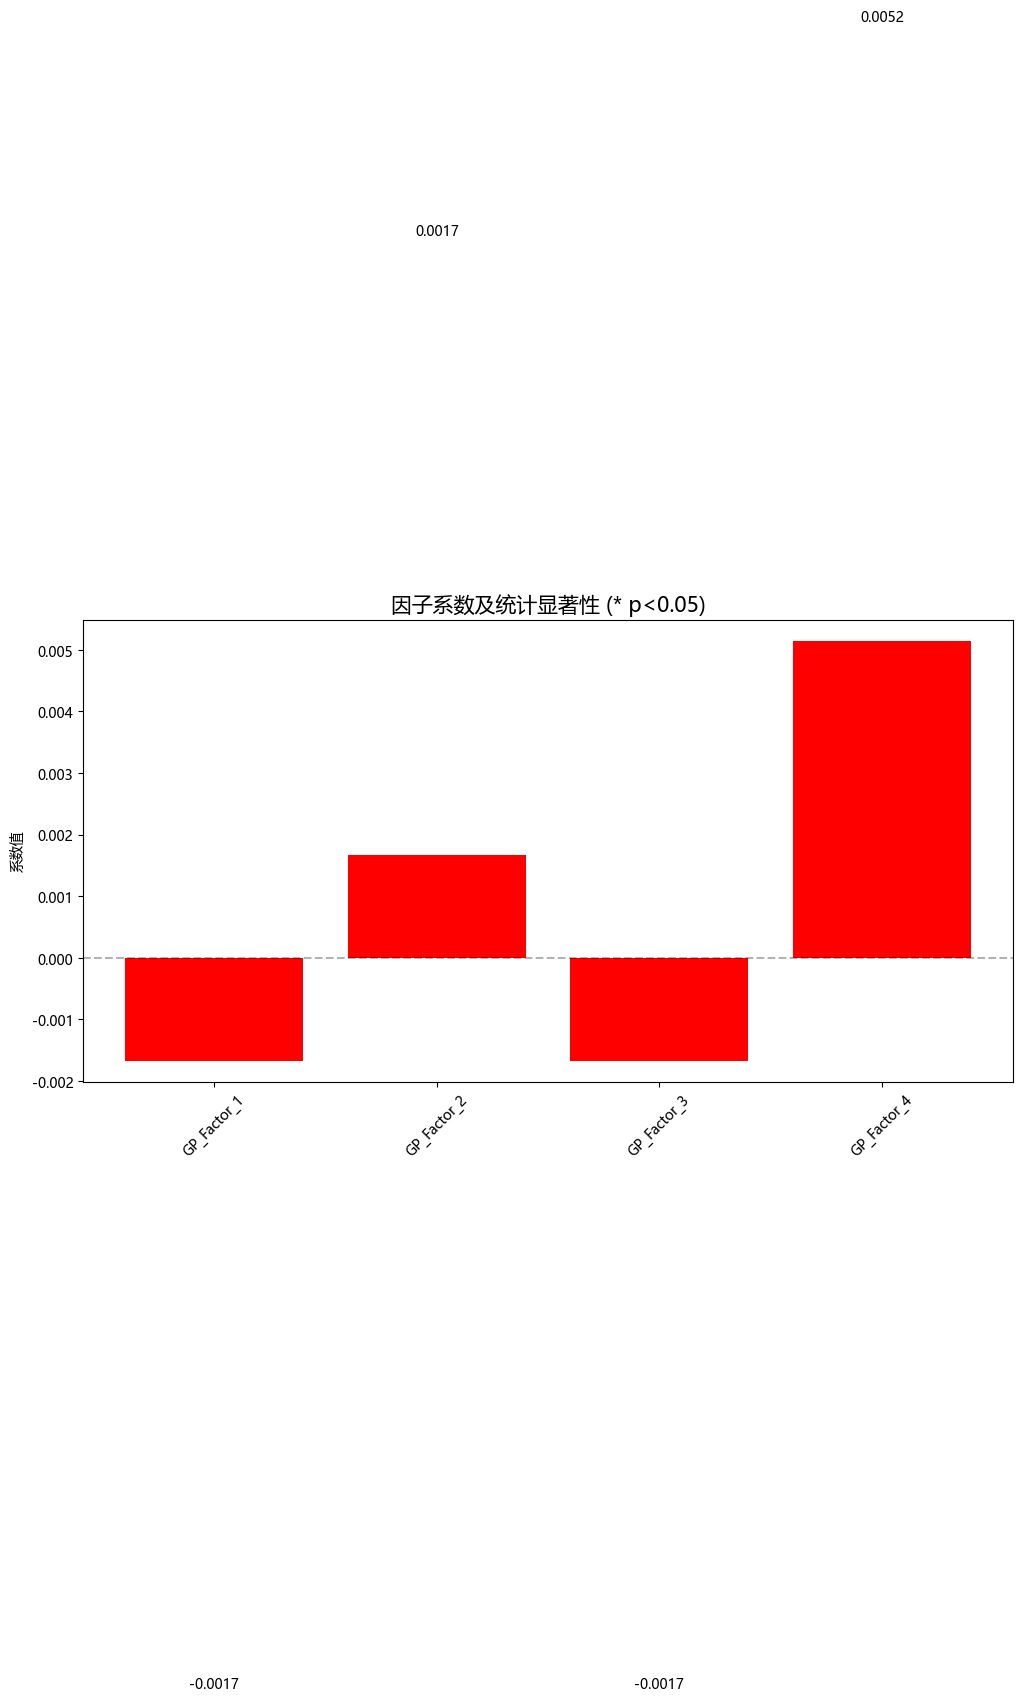

In [ ]:
# 测试股票
test_stock = '600519'  # 贵州茅台
start_date = '2022-01-01'
end_date = '2023-12-31'

# 获取价格数据
price_data = get_price_data(test_stock, start_date, end_date)
if price_data is not None and len(price_data) > 0:
    print(f"获取到{len(price_data)}条价格数据")
    
    # 初始化因子挖掘Agent
    factor_agent = FactorAgent()
    
    # 生成因子
    try:
        print("开始因子挖掘...")
        factors = factor_agent.generate_factors(
            price_data=price_data,
            n_factors=4,
            population_size=50,
            n_generations=20
        )
        print(f"生成了{len(factors)}个因子")
        
        # 获取因子值
        factor_values = factor_agent.get_factor_values(price_data)
        
        # 评估因子表现
        ic_values = evaluate_factor_performance(price_data, factor_values)
        
        # 测试因子显著性
        factor_significance = test_factor_significance(price_data, factor_values)
        
        # 生成交易信号
        signals = factor_agent.generate_signals(price_data)
        print(f"交易信号: {signals.get('signal', 'N/A')}")
        print(f"信号置信度: {signals.get('confidence', 0):.4f}")
        print(f"决策理由: {signals.get('reasoning', 'N/A')}")
        
    except Exception as e:
        print(f"因子挖掘过程中出错: {str(e)}")
else:
    print(f"无法获取{test_stock}的价格数据")

### 2.2 使用协方差矩阵估计进行投资组合优化

INFO:root:Getting price history for 600519 from 2022-01-01 to 2023-12-31
INFO:src.tools.data_source_adapter.cache:Using cached data for price_hist_600519_20220101_20231231_qfq
INFO:root:Successfully retrieved 484 records from cache
2025-05-06 12:32:00 - api - INFO - Successfully processed price data (484 records)
INFO:root:Getting price history for 000858 from 2022-01-01 to 2023-12-31
INFO:src.tools.data_source_adapter.cache:Using cached data for price_hist_000858_20220101_20231231_qfq
INFO:root:Successfully retrieved 484 records from cache
2025-05-06 12:32:00 - api - INFO - Successfully processed price data (484 records)
INFO:root:Getting price history for 601318 from 2022-01-01 to 2023-12-31
INFO:src.tools.data_source_adapter.cache:Using cached data for price_hist_601318_20220101_20231231_qfq
INFO:root:Successfully retrieved 484 records from cache
2025-05-06 12:32:00 - api - INFO - Successfully processed price data (484 records)
INFO:root:Getting price history for 600036 from 2022-01

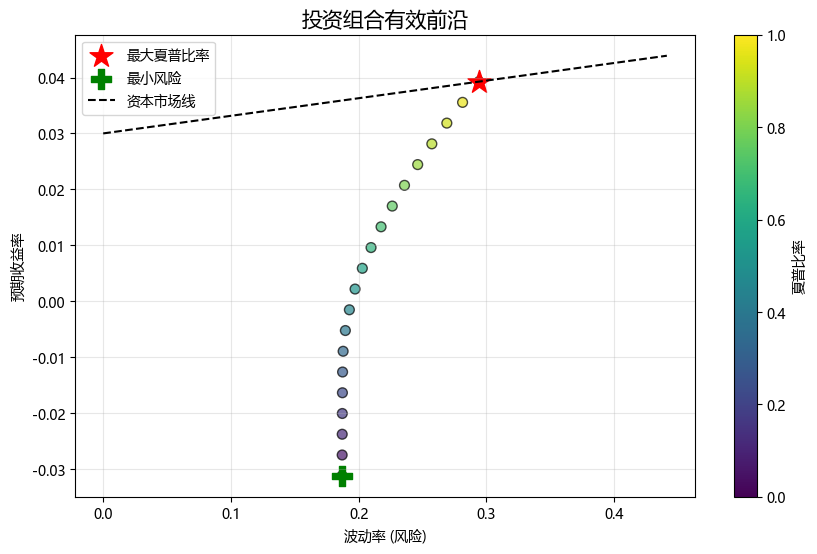

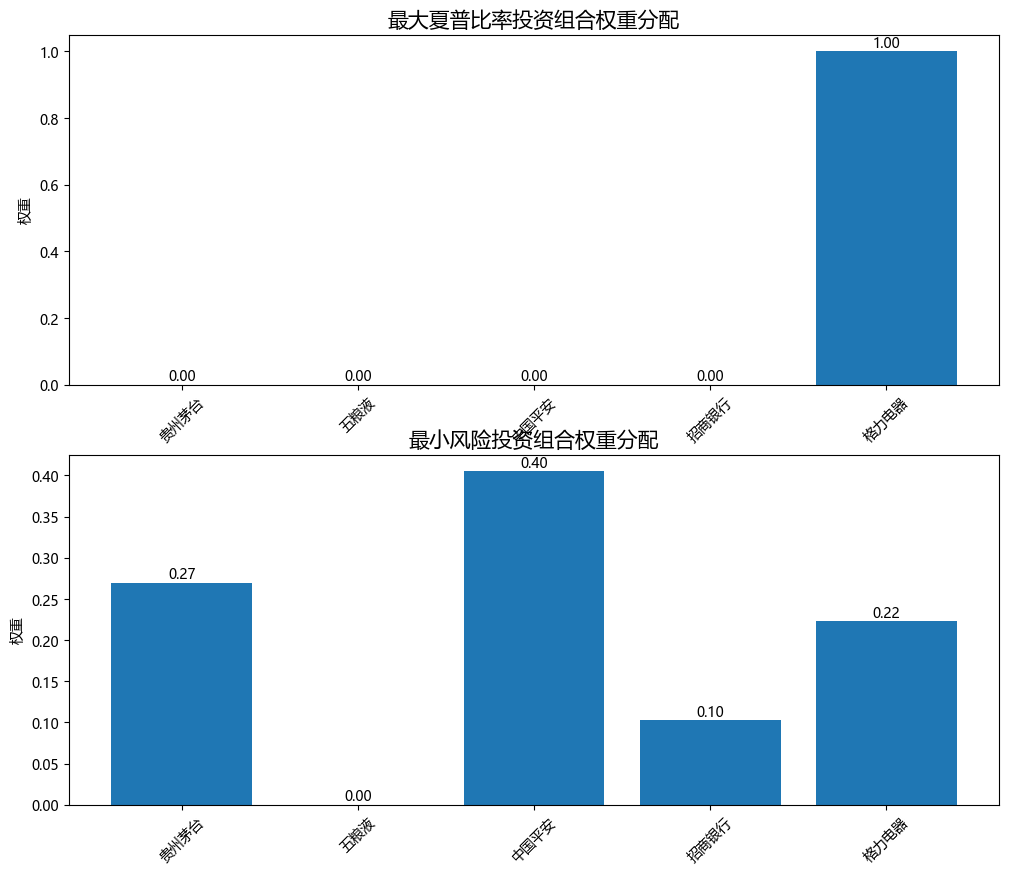

In [ ]:
def build_optimized_portfolio():
    """构建优化投资组合"""
    # 选择股票池
    portfolio_stocks = ['600519', '000858', '601318', '600036', '000651']
    portfolio_names = ['贵州茅台', '五粮液', '中国平安', '招商银行', '格力电器']
    
    # 获取历史数据
    start_date = '2022-01-01'
    end_date = '2023-12-31'
    
    # 构建收益率数据框
    returns_data = {}
    
    for stock in portfolio_stocks:
        try:
            stock_data = get_price_data(stock, start_date, end_date)
            if stock_data is not None and len(stock_data) > 0:
                # 计算日收益率
                stock_data['return'] = stock_data['close'].pct_change().fillna(0)
                # 添加到数据集
                returns_data[stock] = pd.Series(stock_data['return'].values, index=stock_data['date'])
        except Exception as e:
            print(f"获取{stock}数据时出错: {str(e)}")
    
    if not returns_data:
        print("无法获取足够的股票数据")
        return None
    
    # 创建收益率数据框
    returns_df = pd.DataFrame(returns_data)
    
    # 重命名列以使用股票名称
    returns_df.columns = portfolio_names
    
    # 计算预期收益率 (使用历史平均值)
    expected_returns = returns_df.mean() * 252  # 年化
    
    # 使用EWMA估计协方差矩阵
    cov_matrix = estimate_covariance_ewma(returns_df, lambda_param=0.94)
    
    # 计算年化协方差矩阵
    cov_matrix_annual = cov_matrix * 252
    
    # 优化投资组合 - 最大化夏普比率
    max_sharpe_port = optimize_portfolio(
        expected_returns=expected_returns,
        cov_matrix=cov_matrix_annual,
        risk_free_rate=get_risk_free_rate(),
        objective='sharpe'
    )
    
    # 优化投资组合 - 最小风险
    min_risk_port = optimize_portfolio(
        expected_returns=expected_returns,
        cov_matrix=cov_matrix_annual,
        risk_free_rate=get_risk_free_rate(),
        objective='min_risk'
    )
    
    # 计算有效前沿
    ef = efficient_frontier(
        expected_returns=expected_returns,
        cov_matrix=cov_matrix_annual,
        risk_free_rate=get_risk_free_rate(),
        points=20
    )
    
    # 可视化投资组合优化结果
    plt.figure(figsize=(10, 6))
    
    # 绘制有效前沿
    plt.scatter(ef['risk'], ef['return'], c=ef['sharpe_ratio'], 
                cmap='viridis', edgecolors='k', marker='o', s=50, alpha=0.7)
    
    # 标记最大夏普比率和最小风险组合
    plt.scatter(max_sharpe_port['risk'], max_sharpe_port['return'], 
                c='red', marker='*', s=300, label='最大夏普比率')
    plt.scatter(min_risk_port['risk'], min_risk_port['return'], 
                c='green', marker='P', s=200, label='最小风险')
    
    # 添加CML (资本市场线)
    risk_free = get_risk_free_rate()
    plt.plot([0, max_sharpe_port['risk']*1.5], [risk_free, risk_free + max_sharpe_port['risk']*1.5 * max_sharpe_port['sharpe_ratio']], 
             'k--', label='资本市场线')
    
    plt.colorbar(label='夏普比率')
    plt.xlabel('波动率 (风险)')
    plt.ylabel('预期收益率')
    plt.title('投资组合有效前沿', fontsize=15)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.show()
    
    # 可视化投资组合权重
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 1, 1)
    plt.bar(portfolio_names, max_sharpe_port['weights'])
    plt.title('最大夏普比率投资组合权重分配', fontsize=15)
    plt.xticks(rotation=45)
    plt.ylabel('权重')
    for i, weight in enumerate(max_sharpe_port['weights']):
        plt.text(i, weight, f"{weight:.2f}", ha='center', va='bottom')
    
    plt.subplot(2, 1, 2)
    plt.bar(portfolio_names, min_risk_port['weights'])
    plt.title('最小风险投资组合权重分配', fontsize=15)
    plt.xticks(rotation=45)
    plt.ylabel('权重')
    for i, weight in enumerate(min_risk_port['weights']):
        plt.text(i, weight, f"{weight:.2f}", ha='center', va='bottom')
    
     
    plt.show()
    
    return {
        'max_sharpe': max_sharpe_port,
        'min_risk': min_risk_port,
        'efficient_frontier': ef,
        'expected_returns': expected_returns,
        'cov_matrix': cov_matrix_annual
    }

# 运行投资组合优化
portfolio_results = build_optimized_portfolio()

### 2.3 投资组合性能分析与统计检验

In [ ]:
def analyze_portfolio_performance_significance(portfolio_returns, benchmark_returns):
    """分析投资组合相对于基准的超额收益显著性"""
    # 确保输入数据有效
    if portfolio_returns is None or benchmark_returns is None:
        print("投资组合或基准回报数据无效")
        return None
        
    # 确保数据长度匹配
    common_index = portfolio_returns.index.intersection(benchmark_returns.index)
    if len(common_index) == 0:
        print("投资组合和基准回报数据没有共同的时间点")
        return None
        
    portfolio_returns = portfolio_returns.loc[common_index]
    benchmark_returns = benchmark_returns.loc[common_index]
    
    # 计算超额收益率
    excess_returns = portfolio_returns - benchmark_returns
    
    # 描述性统计
    mean_excess = excess_returns.mean()
    std_excess = excess_returns.std()
    t_stat = mean_excess / (std_excess / np.sqrt(len(excess_returns)))
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), len(excess_returns) - 1))
    
    # 信息比率
    information_ratio = mean_excess / std_excess * np.sqrt(252)  # 年化
    
    print("\n投资组合超额收益显著性分析:")
    print(f"平均超额收益率: {mean_excess:.6f}")
    print(f"超额收益标准差: {std_excess:.6f}")
    print(f"t统计量: {t_stat:.4f}")
    print(f"p值: {p_value:.4f}")
    print(f"信息比率(IR): {information_ratio:.4f}")
    print(f"超额收益显著性: {'显著高于基准' if p_value < 0.05 and mean_excess > 0 else '不显著高于基准'}")
    
    # 可视化超额收益分布
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(excess_returns, bins=30, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.axvline(x=mean_excess, color='g', linestyle='-', 
                label=f'平均值: {mean_excess:.4f}')
    plt.title('超额收益分布', fontsize=15)
    plt.xlabel('超额收益率')
    plt.ylabel('频次')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(excess_returns.cumsum(), label='累积超额收益')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('累积超额收益', fontsize=15)
    plt.xlabel('交易日')
    plt.ylabel('累积超额收益')
    plt.legend()
    
    plt.show()
    
    return {
        'mean_excess': mean_excess,
        'std_excess': std_excess,
        't_stat': t_stat,
        'p_value': p_value,
        'information_ratio': information_ratio,
        'significant': p_value < 0.05 and mean_excess > 0
    }

INFO:root:Getting price history for 600519 from 2022-01-01 to 2023-12-31
INFO:src.tools.data_source_adapter.cache:Using cached data for price_hist_600519_20220101_20231231_qfq
INFO:root:Successfully retrieved 484 records from cache
2025-05-06 12:32:00 - api - INFO - Successfully processed price data (484 records)
INFO:root:Getting price history for 000858 from 2022-01-01 to 2023-12-31
INFO:src.tools.data_source_adapter.cache:Using cached data for price_hist_000858_20220101_20231231_qfq
INFO:root:Successfully retrieved 484 records from cache
2025-05-06 12:32:01 - api - INFO - Successfully processed price data (484 records)
INFO:root:Getting price history for 601318 from 2022-01-01 to 2023-12-31
INFO:src.tools.data_source_adapter.cache:Using cached data for price_hist_601318_20220101_20231231_qfq
INFO:root:Successfully retrieved 484 records from cache
2025-05-06 12:32:01 - api - INFO - Successfully processed price data (484 records)
INFO:root:Getting price history for 600036 from 2022-01

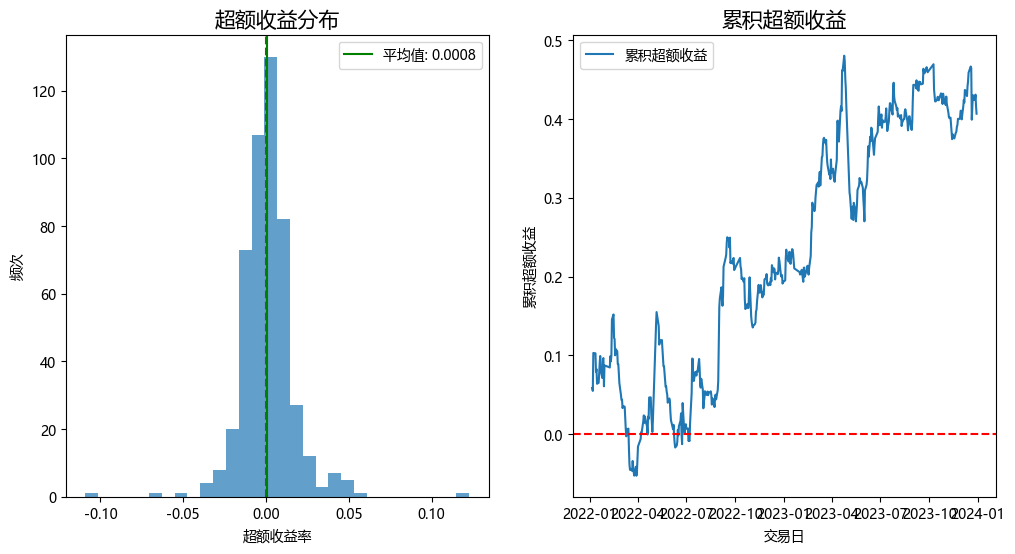

In [ ]:
# 使用投资组合优化结果生成的最优组合权重，计算历史回报
if portfolio_results is not None and 'max_sharpe' in portfolio_results:
    try:
        # 获取最优组合权重
        optimal_weights = portfolio_results['max_sharpe']['weights']
        portfolio_stocks = ['600519', '000858', '601318', '600036', '000651']
        portfolio_names = ['贵州茅台', '五粮液', '中国平安', '招商银行', '格力电器']
        
        # 调试信息
        print("\n投资组合权重:")
        for name, weight in zip(portfolio_names, optimal_weights):
            print(f"{name}: {weight:.4f}")
        
        # 获取原始回报数据
        start_date = '2022-01-01'
        end_date = '2023-12-31'
        
        # 创建日期索引（使用交易日）
        all_dates = pd.date_range(start=start_date, end=end_date, freq='B')
        returns_df = pd.DataFrame(index=all_dates)
        
        # 获取每只股票的收益率并对齐日期
        for i, stock in enumerate(portfolio_stocks):
            stock_data = get_price_data(stock, start_date, end_date)
            if stock_data is not None and len(stock_data) > 0:
                # 计算日收益率
                stock_data['return'] = stock_data['close'].pct_change().fillna(0)
                # 将日期列转换为datetime
                stock_data['date'] = pd.to_datetime(stock_data['date'])
                # 设置为索引以便重采样
                stock_data.set_index('date', inplace=True)
                # 将收益率添加到数据框
                returns_df[portfolio_names[i]] = stock_data['return']
        
        # 删除所有NaN的行
        returns_df.dropna(inplace=True)
        
        if not returns_df.empty:
            # 确保权重匹配列名顺序
            aligned_weights = []
            for col in returns_df.columns:
                idx = portfolio_names.index(col)
                aligned_weights.append(optimal_weights[idx])
            
            # 计算投资组合回报
            returns_df['portfolio'] = 0
            for i, col in enumerate(returns_df.columns[:-1]):  # 除了最后一列'portfolio'
                returns_df['portfolio'] += returns_df[col] * aligned_weights[i]
            
            portfolio_returns = returns_df['portfolio']
            
            # 获取基准回报（这里使用沪深300指数作为基准）
            benchmark_returns = get_market_returns(index_code="000300", start_date=start_date, end_date=end_date)
            
            if benchmark_returns is not None:
                print(f"\n投资组合回报数据形状: {portfolio_returns.shape}")
                print(f"基准回报数据形状: {benchmark_returns.shape}")
                
                # 分析投资组合性能
                performance_analysis = analyze_portfolio_performance_significance(portfolio_returns, benchmark_returns)
            else:
                print("无法获取基准回报数据")
        else:
            print("无法获取足够的股票回报数据进行分析")
    except Exception as e:
        print(f"计算投资组合性能时出错: {str(e)}")
        import traceback
        traceback.print_exc()

## 第三部分：LSTM深度学习模型进行股票价格预测

### 3.1 模型训练与评估

In [ ]:
# 测试股票
test_stock = '600519'  # 贵州茅台
start_date = '2022-01-01'
end_date = '2023-12-31'

# 获取价格数据
price_data = get_price_data(test_stock, start_date, end_date)
price_data

INFO:root:Getting price history for 600519 from 2022-01-01 to 2023-12-31
INFO:src.tools.data_source_adapter.cache:Using cached data for price_hist_600519_20220101_20231231_qfq
INFO:root:Successfully retrieved 484 records from cache
2025-05-06 12:32:01 - api - INFO - Successfully processed price data (484 records)


,date,股票代码,open,close,high,low,volume,amount,amplitude,pct_change,change_amount,turnover,daily_return,true_range,typical_price,ma5,ma20
0,2022-01-04,600519,1911.64,1907.87,1925.59,1870.64,33843,6.913653e+09,2.88,0.06,1.23,0.27,NaN,54.95,1901.366667,NaN,NaN
1,2022-01-05,600519,1901.64,1880.64,1921.64,1874.64,28396,5.774992e+09,2.46,-1.43,-27.23,0.23,-0.014272,47.00,1892.306667,NaN,NaN
2,2022-01-06,600519,1878.65,1838.86,1892.64,1795.15,51795,1.022693e+10,5.18,-2.22,-41.78,0.41,-0.022216,97.49,1842.216667,NaN,NaN
3,2022-01-07,600519,1831.64,1798.64,1845.52,1795.96,29817,5.831695e+09,2.70,-2.19,-40.22,0.24,-0.021872,49.56,1813.373333,NaN,NaN
4,2022-01-10,600519,1784.65,1822.64,1833.64,1774.19,29627,5.792738e+09,3.31,1.33,24.00,0.24,0.013343,59.45,1810.156667,1849.730,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,2023-12-25,600519,1616.24,1617.24,1623.84,1613.24,12471,2.086014e+09,0.66,0.08,1.35,0.10,0.000835,10.60,1618.106667,1608.908,1630.5345
480,2023-12-26,600519,1617.74,1615.24,1620.14,1602.74,14771,2.457177e+09,1.08,-0.12,-2.00,0.12,-0.001237,17.40,1612.706667,1611.728,1626.5375
481,2023-12-27,600519,1613.24,1612.30,1622.39,1606.24,16056,2.679221e+09,1.00,-0.18,-2.94,0.13,-0.001820,16.15,1613.643333,1615.182,1622.1100
482,2023-12-28,600519,1616.23,1670.23,1673.23,1612.30,38338,6.537401e+09,3.78,3.59,57.93,0.31,0.035930,60.93,1651.920000,1626.180,1619.7395


INFO:deep_learning:深度学习模块初始化完成，使用设备: cpu
INFO:deep_learning:开始训练LSTM模型...
INFO:deep_learning:Epoch 1/50, Training Loss: 0.0929, Validation Loss: 0.0091
INFO:deep_learning:Epoch 6/50, Training Loss: 0.0079, Validation Loss: 0.0047
INFO:deep_learning:Epoch 11/50, Training Loss: 0.0066, Validation Loss: 0.0049
INFO:deep_learning:Epoch 16/50, Training Loss: 0.0060, Validation Loss: 0.0028
INFO:deep_learning:Epoch 21/50, Training Loss: 0.0044, Validation Loss: 0.0043
INFO:deep_learning:Epoch 26/50, Training Loss: 0.0037, Validation Loss: 0.0019
INFO:deep_learning:Epoch 31/50, Training Loss: 0.0034, Validation Loss: 0.0018
INFO:deep_learning:Epoch 36/50, Training Loss: 0.0034, Validation Loss: 0.0019
INFO:deep_learning:Epoch 41/50, Training Loss: 0.0030, Validation Loss: 0.0015
INFO:deep_learning:Epoch 46/50, Training Loss: 0.0029, Validation Loss: 0.0017
INFO:deep_learning:LSTM模型训练完成
INFO:deep_learning:开始训练随机森林分类器...
INFO:deep_learning:分类器训练完成，训练准确率: 1.0000, 验证准确率: 0.8202
INFO:deep_learning

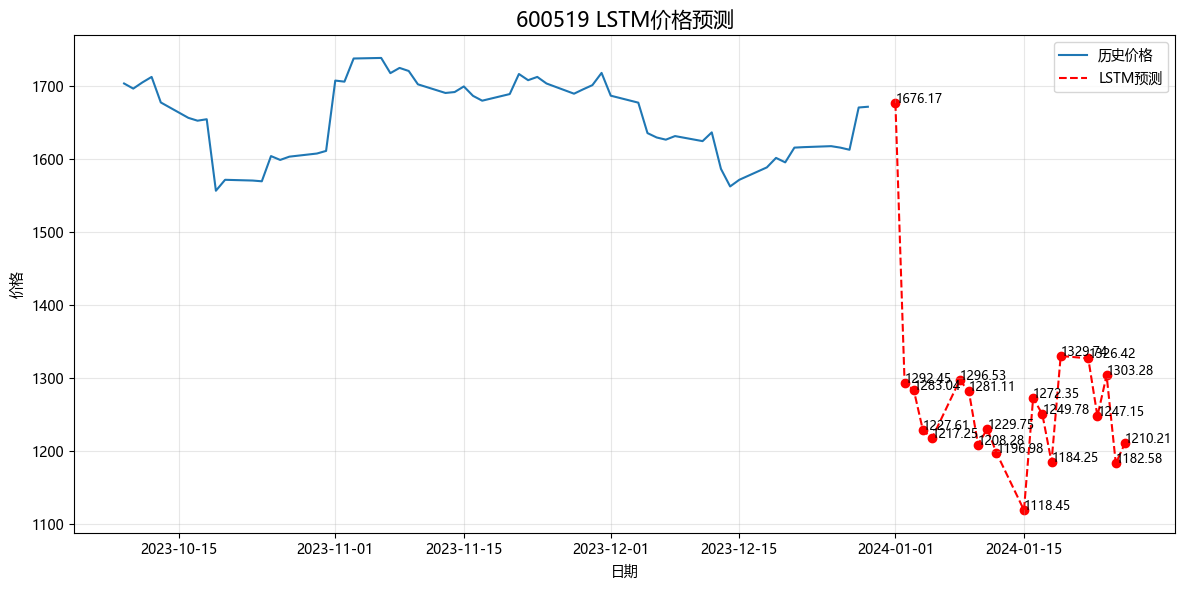

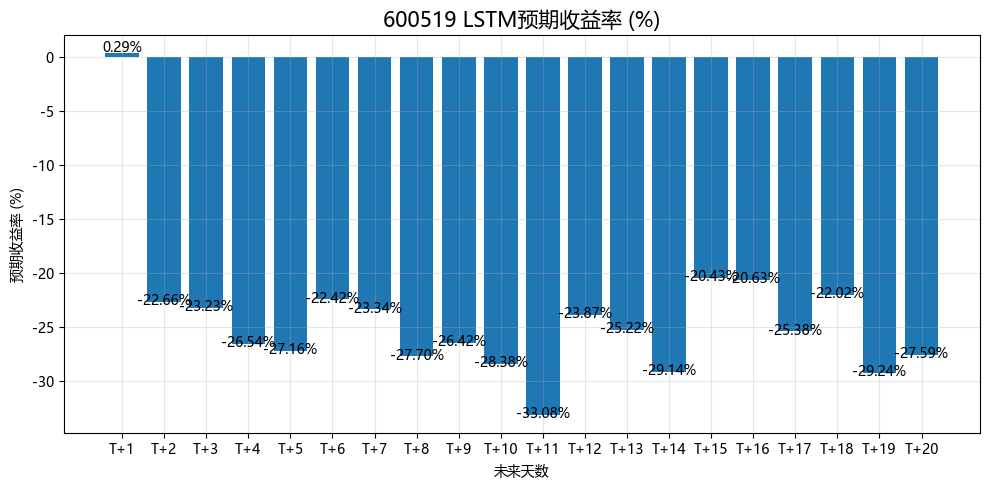

In [ ]:
if price_data is not None and len(price_data) > 0:
    print(f"获取到{len(price_data)}条价格数据")

    # 数据预处理
    processed_data = preprocess_stock_data(price_data)
    
    # 确保processed_data的索引是日期类型
    if not isinstance(processed_data.index, pd.DatetimeIndex):
        processed_data.index = pd.to_datetime(processed_data.index)
    
    # 统一日期格式为YYYY-MM-DD以避免时区等问题
    processed_data.index = pd.to_datetime(processed_data.index.strftime('%Y-%m-%d'))
    
    # 初始化深度学习 Agent
    ml_agent = MLAgent(model_dir='models')
    
    # 训练模型
    print("开始训练模型...")
    try:
        ml_agent.train_models(processed_data)
        print("模型训练完成")
        
        # 生成预测信号
        signals = ml_agent.generate_signals(processed_data)
        
        print(f"LSTM预测信号: {signals.get('lstm_signal', 'N/A')}")
        print(f"随机森林预测信号: {signals.get('rf_signal', 'N/A')}")
        print(f"综合信号: {signals.get('signal', 'N/A')}")
        print(f"置信度: {signals.get('confidence', 0):.4f}")
        print(f"决策理由: {signals.get('reasoning', 'N/A')}")
        
        # 可视化LSTM预测结果
        if 'lstm_predictions' in signals:
            future_prices = signals['lstm_predictions']['future_prices']
            expected_returns = signals['lstm_predictions']['expected_returns']
            
            # 获取最新价格
            last_price = processed_data['close'].iloc[-1]
            
            # 预测日期
            # 确保索引是日期类型
            last_date = processed_data.index[-1]
            
            # 创建工作日日期范围（B = business day）
            future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                                        periods=len(future_prices), 
                                        freq='B')
            
            # 标准化日期格式为YYYY-MM-DD
            future_dates = pd.to_datetime(future_dates.strftime('%Y-%m-%d'))
            
            print(f"最后交易日: {last_date}")
            print(f"预测日期: {[d.strftime('%Y-%m-%d') for d in future_dates]}")
            
            # 历史价格
            plt.figure(figsize=(12, 6))
            plt.plot(processed_data.index[-60:], processed_data['close'].iloc[-60:], label='历史价格')
            
            # 预测价格
            plt.plot(future_dates, future_prices, 'r--', label='LSTM预测')
            plt.scatter(future_dates, future_prices, color='red')
            
            # 添加价格标签
            for i, (date, price) in enumerate(zip(future_dates, future_prices)):
                plt.text(date, price, f"{price:.2f}", fontsize=9)
            
            plt.title(f'{test_stock} LSTM价格预测', fontsize=15)
            plt.xlabel('日期')
            plt.ylabel('价格')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            # 预期收益率
            plt.figure(figsize=(10, 5))
            plt.bar(range(len(expected_returns)), [r*100 for r in expected_returns])
            plt.title(f'{test_stock} LSTM预期收益率 (%)', fontsize=15)
            plt.xlabel('未来天数')
            plt.ylabel('预期收益率 (%)')
            plt.xticks(range(len(expected_returns)), [f'T+{i+1}' for i in range(len(expected_returns))])
            
            for i, ret in enumerate(expected_returns):
                plt.text(i, ret*100 + (0.1 if ret > 0 else -0.3), f"{ret*100:.2f}%", ha='center')
            
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"模型训练过程中出错: {str(e)}")
        import traceback
        traceback.print_exc()  # 打印详细错误栈，有助于调试
else:
    print(f"无法获取{test_stock}的价格数据")

### 3.2 预测能力的统计显著性检验

In [ ]:
def evaluate_prediction_significance(predictions, actual_returns):
    """评估预测能力的统计显著性"""
    # 将预测和实际结果合并
    data = pd.DataFrame({
        'predicted': predictions,
        'actual': actual_returns
    }).dropna()
    
    if len(data) < 10:
        print("有效数据不足，无法进行预测显著性检验")
        return None
    
    # 计算预测准确率 (方向准确率)
    accuracy = np.mean((data['predicted'] > 0) == (data['actual'] > 0))
    
    # 计算Spearman秩相关系数
    correlation, p_value = stats.spearmanr(data['predicted'], data['actual'])
    
    # 进行符号检验 (Signtest) - 检验预测方向的准确性是否显著高于随机猜测
    num_correct = sum((data['predicted'] > 0) == (data['actual'] > 0))
    n = len(data)
    sign_p_value = stats.binom_test(num_correct, n, 0.5, alternative='greater')
    
    print("\n预测能力显著性分析:")
    print(f"样本数量: {n}")
    print(f"方向准确率: {accuracy:.4f}")
    print(f"Spearman相关系数: {correlation:.4f} (p值: {p_value:.4f})")
    print(f"符号检验p值: {sign_p_value:.4f}")
    print(f"预测能力: {'显著高于随机' if sign_p_value < 0.05 else '不显著高于随机'}")
    
    # 可视化预测与实际值的散点图
    plt.figure(figsize=(10, 6))
    plt.scatter(data['predicted'], data['actual'], alpha=0.5)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    
    # 添加回归线
    slope, intercept, r_value, p_value, std_err = stats.linregress(data['predicted'], data['actual'])
    x = np.linspace(min(data['predicted']), max(data['predicted']), 100)
    plt.plot(x, intercept + slope*x, 'r', 
             label=f'回归线 (斜率={slope:.4f}, R²={r_value**2:.4f}, p={p_value:.4f})')
    
    plt.title('预测值 vs 实际值 散点图', fontsize=15)
    plt.xlabel('预测值')
    plt.ylabel('实际值')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'correlation': correlation,
        'correlation_p_value': p_value,
        'sign_test_p_value': sign_p_value,
        'significant': sign_p_value < 0.05
    }

INFO:root:Getting price history for 600519 from 2023-12-30 to 2024-02-07
INFO:src.tools.data_source_adapter.cache:Using cached data for price_hist_600519_20231230_20240207_qfq
INFO:root:Successfully retrieved 27 records from cache
2025-05-06 12:32:09 - api - INFO - Successfully processed price data (27 records)
C:\Users\15170\AppData\Local\Temp\ipykernel_9160\2875933197.py:22: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  sign_p_value = stats.binom_test(num_correct, n, 0.5, alternative='greater')


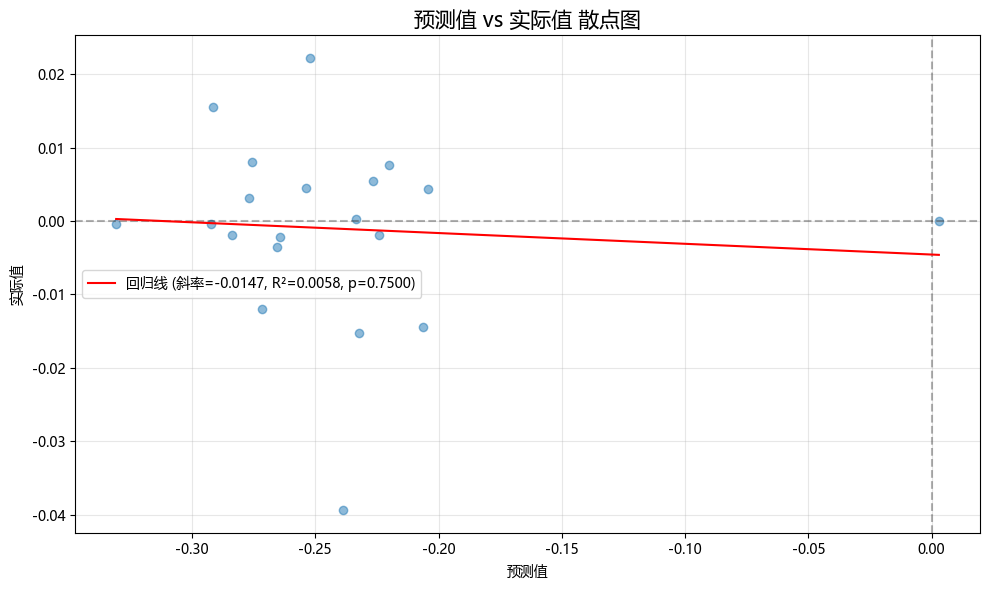

In [ ]:
if 'signals' in globals() and signals and 'lstm_predictions' in signals:
    try:
        # 获取LSTM预测
        future_prices = signals['lstm_predictions'].get('future_prices', [])
        expected_returns = signals['lstm_predictions'].get('expected_returns', [])
        
        # 获取预测时间之后的实际数据
        last_date = processed_data.index[-1] if 'processed_data' in globals() else None
        
        if last_date is not None:
            # 计算预测开始日期后的实际价格
            prediction_start_date = last_date + pd.Timedelta(days=1)
            prediction_end_date = last_date + pd.Timedelta(days=len(future_prices)*2)  # 稍微多获取一些日期
            
            actual_future_data = get_price_data(test_stock, 
                                               start_date=prediction_start_date.strftime('%Y-%m-%d'), 
                                               end_date=prediction_end_date.strftime('%Y-%m-%d'))
            
            if actual_future_data is not None and len(actual_future_data) > 0:
                # 计算实际收益率
                actual_future_data['return'] = actual_future_data['close'].pct_change().fillna(0)
                
                # 使用实际的每日收益率作为比较数据
                actual_daily_returns = actual_future_data['return'].values
                
                # 确保长度匹配（取较短的长度）
                min_length = min(len(expected_returns), len(actual_daily_returns))
                
                if min_length > 0:
                    # 截取相同长度的数据
                    predictions = np.array(expected_returns[:min_length])
                    actual = np.array(actual_daily_returns[:min_length])
                    
                    # 评估预测能力
                    prediction_significance = evaluate_prediction_significance(predictions, actual)
                else:
                    print("没有足够的预测或实际数据进行比较")
            else:
                print("无法获取预测期间的实际价格数据")
        else:
            print("无法确定预测的起始日期")
    except Exception as e:
        print(f"评估预测能力时出错: {str(e)}")
        import traceback
        traceback.print_exc()

## 第四部分：基于强化学习的交易策略开发

### 4.1 模型训练与信号生成

INFO:root:Getting price history for 600519 from 2022-01-01 to 2023-12-31
INFO:src.tools.data_source_adapter.cache:Using cached data for price_hist_600519_20220101_20231231_qfq
INFO:root:Successfully retrieved 484 records from cache
2025-05-06 12:32:09 - api - INFO - Successfully processed price data (484 records)
INFO:reinforcement_learning:PPO代理初始化完成，使用设备: cpu
INFO:rl_trader:开始训练，共500轮...
INFO:rl_trader:模型保存至 models\best_model.pth
INFO:rl_trader:模型保存至 models\best_model.pth
INFO:rl_trader:模型保存至 models\best_model.pth
INFO:rl_trader:模型保存至 models\best_model.pth
INFO:rl_trader:Episode 10/500, Avg Reward: 0.0342, Avg Portfolio: 106816.29
INFO:rl_trader:Episode 20/500, Avg Reward: 0.0389, Avg Portfolio: 99503.69
INFO:rl_trader:模型保存至 models\best_model.pth
INFO:rl_trader:Episode 30/500, Avg Reward: 0.0430, Avg Portfolio: 99398.64
INFO:rl_trader:模型保存至 models\best_model.pth
INFO:rl_trader:模型保存至 models\best_model.pth
INFO:rl_trader:Episode 40/500, Avg Reward: 0.0515, Avg Portfolio: 102101.89
INFO

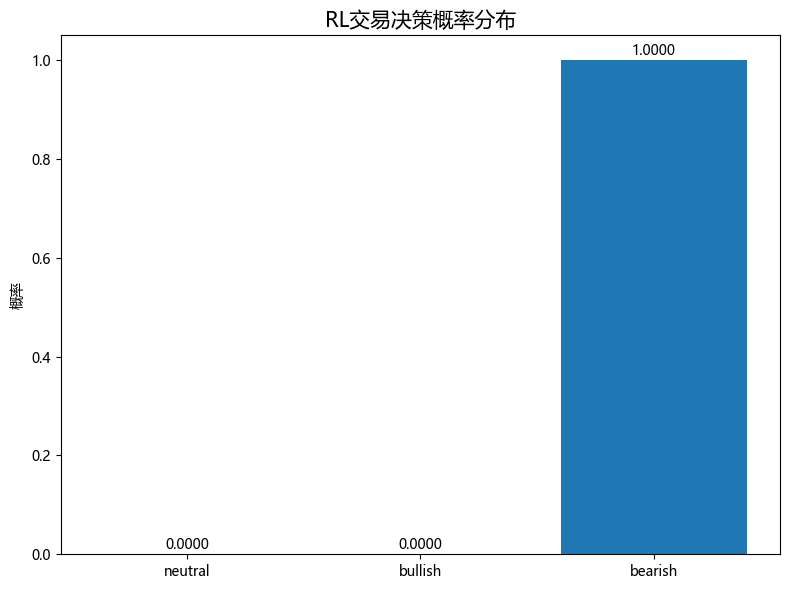

In [ ]:
# 测试股票
test_stock = '600519'  # 贵州茅台
start_date = '2022-01-01'
end_date = '2023-12-31'

# 获取价格数据
price_data = get_price_data(test_stock, start_date, end_date)
if price_data is not None and len(price_data) > 0:
    print(f"获取到{len(price_data)}条价格数据")

    # 初始化RL交易 Agent
    rl_agent = RLTradingAgent(model_dir='models')
    
    # 训练模型
    print("开始训练RL模型...")
    try:
        training_history = rl_agent.train(price_data)
        print("RL模型训练完成")
        
        # 生成交易信号
        rl_signals = rl_agent.generate_signals(price_data)
        
        print(f"RL交易信号: {rl_signals.get('signal', 'N/A')}")
        print(f"置信度: {rl_signals.get('confidence', 0):.4f}")
        print(f"决策理由: {rl_signals.get('reasoning', 'N/A')}")
        
        # 可视化动作概率分布
        if 'action_probs' in rl_signals:
            action_probs = rl_signals['action_probs']
            
            plt.figure(figsize=(8, 6))
            plt.bar(action_probs.keys(), action_probs.values())
            plt.title('RL交易决策概率分布', fontsize=15)
            plt.ylabel('概率')
            
            for i, (k, v) in enumerate(action_probs.items()):
                plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
            
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"RL模型训练过程中出错: {str(e)}")
else:
    print(f"无法获取{test_stock}的价格数据")

### 4.2 回测评估

In [ ]:
def run_simple_backtest(ticker, start_date, end_date, initial_capital=100000):
    """运行简单的回测"""
    import uuid
    run_id = str(uuid.uuid4())
    
    # 创建回测器
    backtester = Backtester(
        agent=run_hedge_fund,
        ticker=ticker,
        start_date=start_date,
        end_date=end_date,
        initial_capital=initial_capital,
        num_of_news=5
    )
    
    # 运行回测
    try:
        backtester.run_backtest()
        
        # 分析性能并返回
        return backtester.analyze_performance()
    except Exception as e:
        import pandas as pd
        return pd.DataFrame({'error': [str(e)]})

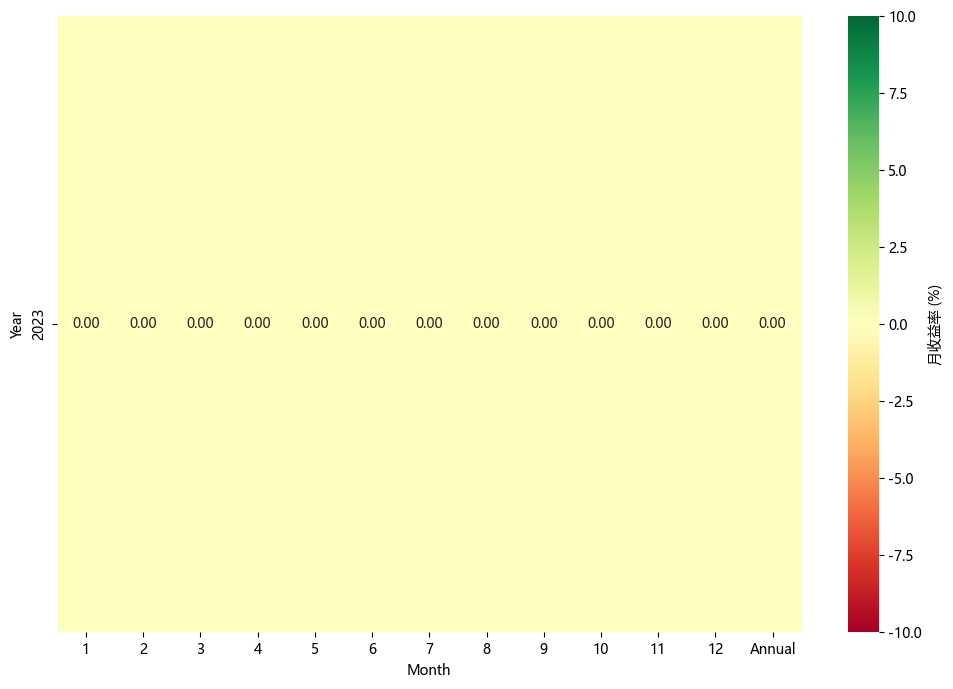

: 

In [ ]:
backtest_start = '2023-01-01'
backtest_end = '2023-12-31'

performance_df = run_simple_backtest(test_stock, backtest_start, backtest_end)

In [ ]:
performance_df

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(performance_df.index, performance_df['Cumulative Return'], label='累积收益率')
plt.title(f'{test_stock} 回测累积收益率 (期间: {backtest_start} 至 {backtest_end})', fontsize=15)
plt.xlabel('日期')
plt.ylabel('累积收益率 (%)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# 绘制每日收益率分布
plt.figure(figsize=(10, 6))
plt.hist(performance_df['Daily Return'], bins=30, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('每日收益率分布', fontsize=15)
plt.xlabel('每日收益率 (%)')
plt.ylabel('频次')

plt.tight_layout()
plt.show()

AttributeError: 'NoneType' object has no attribute 'index'

<Figure size 1200x600 with 0 Axes>

## 第五部分：风险管理框架建立

### 5.1 波动率模型实现与评估

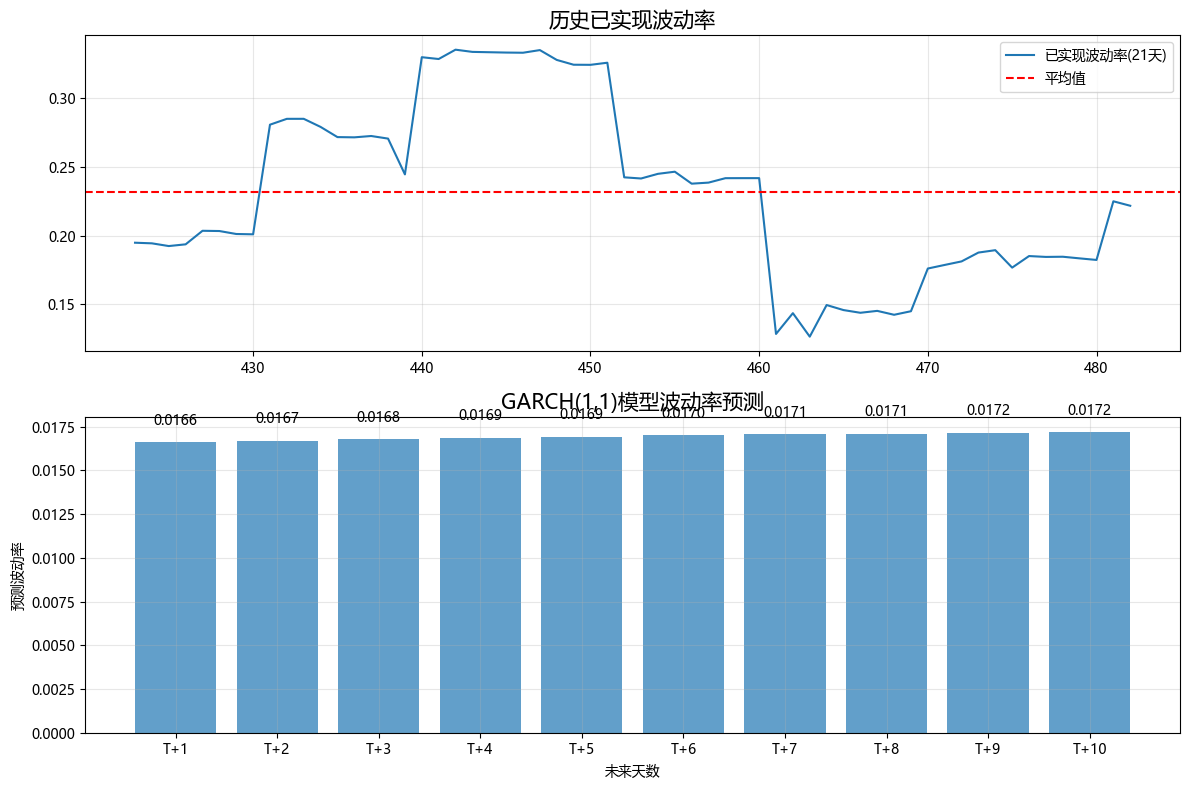

In [ ]:
def analyze_volatility(price_data):
    """分析股票波动率"""
    if price_data is None or len(price_data) < 30:
        print("数据不足，无法进行波动率分析")
        return None
        
    # 计算日收益率
    returns = price_data['close'].pct_change().dropna().values
    
    # 计算已实现波动率
    realized_vol = calculate_realized_volatility(
        pd.Series(returns), 
        window=21,  # 21天窗口
        annualize=True  # 年化
    )
    
    # 拟合GARCH(1,1)模型
    try:
        garch_params, loglik = fit_garch(returns)
        
        print("\nGARCH(1,1)模型参数:")
        print(f"omega: {garch_params['omega']:.6f}")
        print(f"alpha: {garch_params['alpha']:.4f}")
        print(f"beta: {garch_params['beta']:.4f}")
        print(f"持续性(alpha+beta): {garch_params['persistence']:.4f}")
        print(f"长期方差: {garch_params['long_run_variance']:.6f}")
        
        # 预测未来波动率
        forecast_horizon = 10
        forecast_vol = forecast_garch_volatility(
            returns=returns,
            params=garch_params,
            forecast_horizon=forecast_horizon
        )
        
        # 可视化波动率
        plt.figure(figsize=(12, 8))
        
        # 历史已实现波动率
        plt.subplot(2, 1, 1)
        plt.plot(realized_vol[-60:], label='已实现波动率(21天)')
        plt.title('历史已实现波动率', fontsize=15)
        
        # 添加均线
        plt.axhline(y=realized_vol[-60:].mean(), color='r', linestyle='--', label='平均值')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 未来波动率预测
        plt.subplot(2, 1, 2)
        plt.bar(range(forecast_horizon), forecast_vol, alpha=0.7)
        plt.title('GARCH(1,1)模型波动率预测', fontsize=15)
        plt.xlabel('未来天数')
        plt.ylabel('预测波动率')
        plt.xticks(range(forecast_horizon), [f'T+{i+1}' for i in range(forecast_horizon)])
        
        # 添加数值标签
        for i, vol in enumerate(forecast_vol):
            plt.text(i, vol + 0.001, f"{vol:.4f}", ha='center')
        
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return {
            'realized_vol': realized_vol,
            'garch_params': garch_params,
            'forecast_vol': forecast_vol
        }
        
    except Exception as e:
        print(f"波动率分析过程中出错: {str(e)}")
        return None

# 分析股票波动率
if price_data is not None and len(price_data) > 0:
    volatility_results = analyze_volatility(price_data)

### 5.2 尾部风险度量 - VaR和CVaR计算

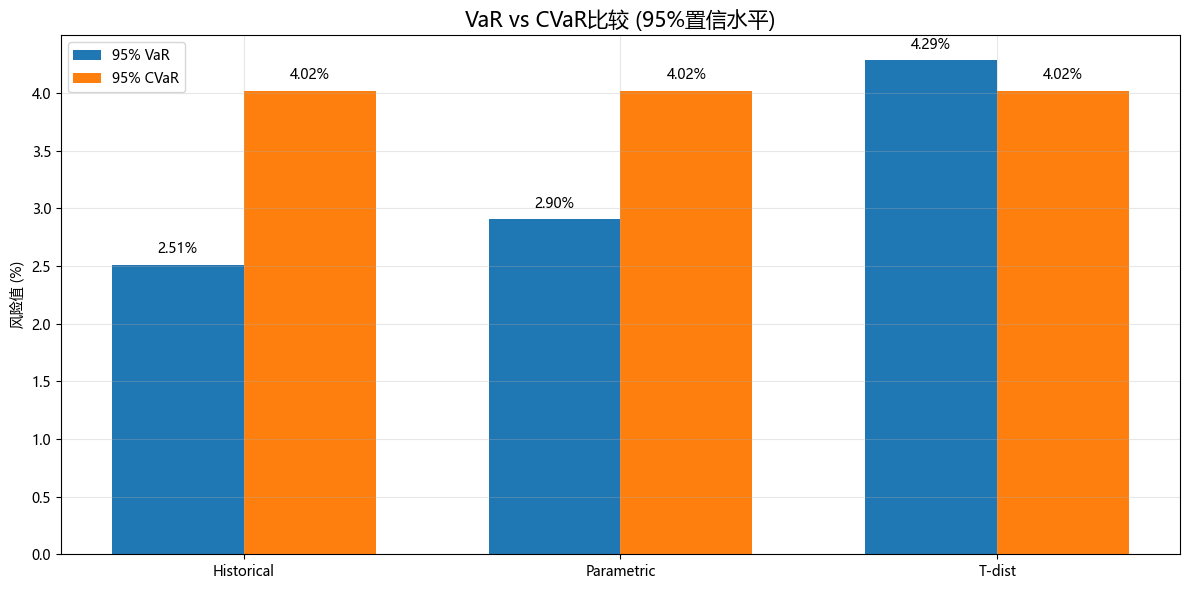

In [ ]:
def analyze_tail_risk(price_data):
    """分析尾部风险"""
    if price_data is None or len(price_data) < 30:
        print("数据不足，无法进行尾部风险分析")
        return None
        
    # 计算日收益率
    returns = price_data['close'].pct_change().dropna()
    
    # 计算不同置信水平的VaR和CVaR
    confidence_levels = [0.90, 0.95, 0.99]
    var_results = {}
    cvar_results = {}
    
    for cl in confidence_levels:
        # 历史模拟法VaR
        hist_var = calculate_historical_var(returns, confidence_level=cl)
        var_results[f'Historical_{cl}'] = hist_var
        
        # 参数法VaR (正态分布)
        param_var = calculate_parametric_var(returns, confidence_level=cl, distribution='normal')
        var_results[f'Parametric_{cl}'] = param_var
        
        # 参数法VaR (t分布)
        t_var = calculate_parametric_var(returns, confidence_level=cl, distribution='t')
        var_results[f'T-dist_{cl}'] = t_var
        
        # 条件风险价值(CVaR/Expected Shortfall)
        cvar = calculate_conditional_var(returns, confidence_level=cl)
        cvar_results[f'CVaR_{cl}'] = cvar
    
    # 打印结果
    print("\n尾部风险分析结果:")
    for method, var in var_results.items():
        print(f"{method} VaR: {var*100:.4f}%")
    
    for method, cvar in cvar_results.items():
        print(f"{method}: {cvar*100:.4f}%")
    
    # 可视化VaR和CVaR对比
    plt.figure(figsize=(12, 6))
    
    # 组织数据
    methods = ['Historical', 'Parametric', 'T-dist']
    var_95 = [var_results[f'{m}_0.95'] * 100 for m in methods]
    cvar_95 = [cvar_results[f'CVaR_0.95'] * 100] * len(methods)  # 使用相同的CVaR值
    
    x = np.arange(len(methods))
    width = 0.35
    
    # 绘制柱状图
    plt.bar(x - width/2, var_95, width, label='95% VaR')
    plt.bar(x + width/2, cvar_95, width, label='95% CVaR')
    
    plt.ylabel('风险值 (%)')
    plt.title('VaR vs CVaR比较 (95%置信水平)', fontsize=15)
    plt.xticks(x, methods)
    plt.legend()
    
    # 添加数值标签
    for i, v in enumerate(var_95):
        plt.text(i - width/2, v + 0.1, f"{v:.2f}%", ha='center')
    
    for i, v in enumerate(cvar_95):
        plt.text(i + width/2, v + 0.1, f"{v:.2f}%", ha='center')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 回测VaR模型
    try:
        window = min(252, len(returns) // 2)  # 使用不超过1年或数据一半的窗口
        var_backtest = backtesting_var(returns, var_method='historical', confidence_level=0.95, window=window)
        
        print("\nVaR回测结果:")
        print(f"观察期数: {var_backtest['observation_count']}")
        print(f"VaR违反次数: {var_backtest['violations']}")
        print(f"实际违反率: {var_backtest['violation_rate']:.4f}")
        print(f"期望违反率: {var_backtest['expected_rate']:.4f}")
        if var_backtest['kupiec_pvalue'] is not None:
            print(f"Kupiec检验p值: {var_backtest['kupiec_pvalue']:.4f}")
            print(f"Kupiec检验结果: {'通过' if var_backtest['kupiec_pvalue'] > 0.05 else '不通过'}")
    
    except Exception as e:
        print(f"VaR回测过程中出错: {str(e)}")
    
    return {
        'var_results': var_results,
        'cvar_results': cvar_results
    }

# 分析尾部风险
if price_data is not None and len(price_data) > 0:
    tail_risk_results = analyze_tail_risk(price_data)

### 5.3 风险调整收益比率分析

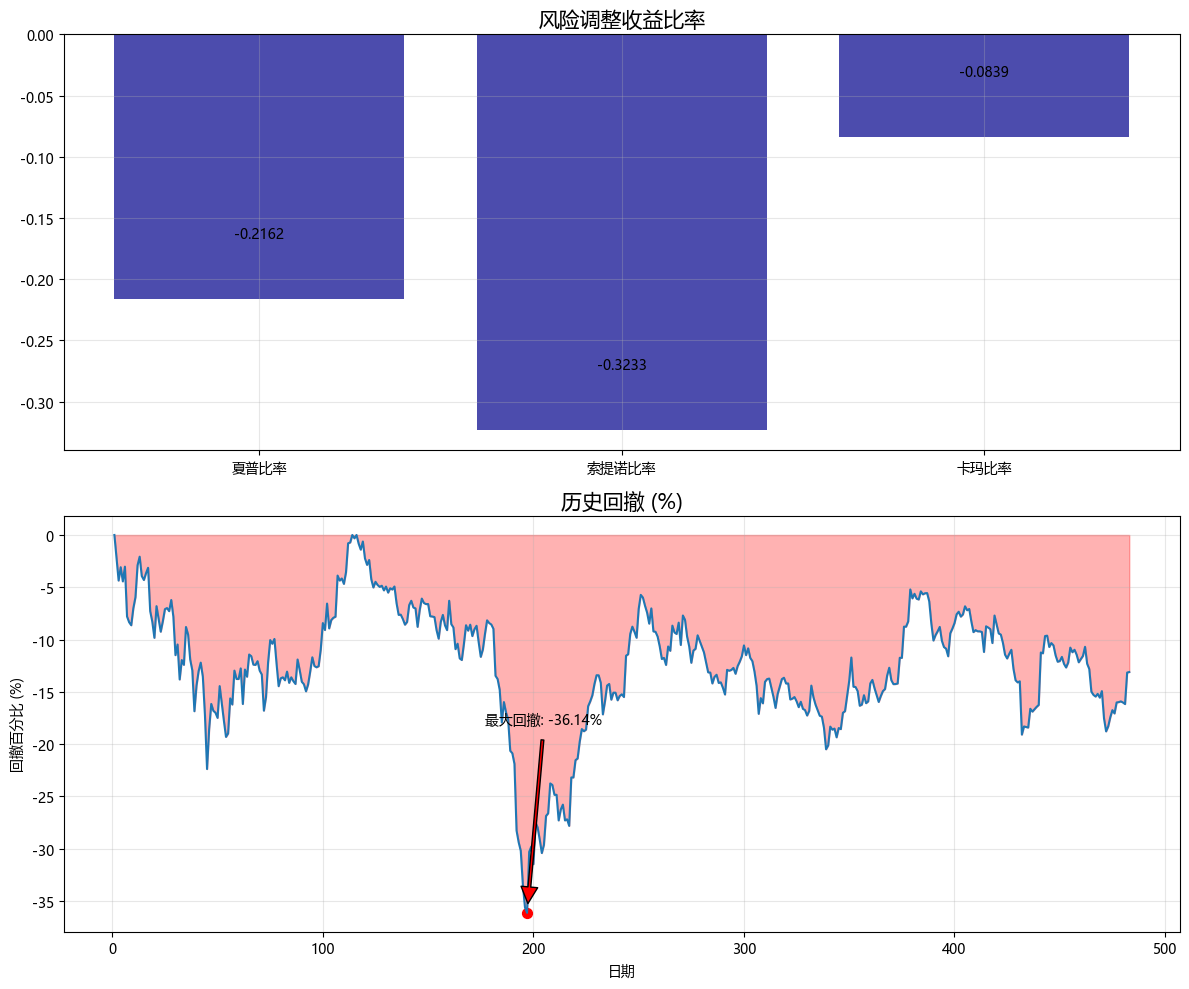

In [ ]:
def analyze_risk_adjusted_returns(price_data):
    """分析风险调整收益比率"""
    if price_data is None or len(price_data) < 30:
        print("数据不足，无法进行风险调整收益比率分析")
        return None
        
    # 计算日收益率
    returns = price_data['close'].pct_change().dropna()
    
    # 计算年化收益率
    annual_return = returns.mean() * 252
    
    # 计算年化波动率
    annual_vol = returns.std() * np.sqrt(252)
    
    # 计算夏普比率
    risk_free_rate = get_risk_free_rate()
    sharpe_ratio = (annual_return - risk_free_rate) / annual_vol
    
    # 计算索提诺比率
    downside_returns = returns[returns < 0]
    downside_deviation = downside_returns.std() * np.sqrt(252)
    sortino_ratio = (annual_return - risk_free_rate) / downside_deviation
    
    # 计算最大回撤
    cum_returns = (1 + returns).cumprod()
    rolling_max = cum_returns.cummax()
    drawdown = (cum_returns / rolling_max - 1)
    max_drawdown = drawdown.min()
    
    # 计算卡玛比率
    calmar_ratio = annual_return / abs(max_drawdown)
    
    # 打印结果
    print("\n风险调整收益比率分析结果:")
    print(f"年化收益率: {annual_return:.4f} ({annual_return*100:.2f}%)")
    print(f"年化波动率: {annual_vol:.4f} ({annual_vol*100:.2f}%)")
    print(f"夏普比率: {sharpe_ratio:.4f}")
    print(f"索提诺比率: {sortino_ratio:.4f}")
    print(f"最大回撤: {max_drawdown:.4f} ({max_drawdown*100:.2f}%)")
    print(f"卡玛比率: {calmar_ratio:.4f}")
    
    # 可视化风险指标
    plt.figure(figsize=(12, 10))
    
    metrics = ['夏普比率', '索提诺比率', '卡玛比率']
    values = [sharpe_ratio, sortino_ratio, calmar_ratio]
    
    plt.subplot(2, 1, 1)
    plt.bar(metrics, values, color='darkblue', alpha=0.7)
    plt.title('风险调整收益比率', fontsize=15)
    plt.grid(True, alpha=0.3)
    
    # 添加数值标签
    for i, v in enumerate(values):
        plt.text(i, v + 0.05, f"{v:.4f}", ha='center')
    
    # 绘制回撤图
    plt.subplot(2, 1, 2)
    plt.plot(drawdown*100)
    plt.fill_between(drawdown.index, drawdown*100, 0, alpha=0.3, color='red')
    plt.title('历史回撤 (%)', fontsize=15)
    plt.xlabel('日期')
    plt.ylabel('回撤百分比 (%)')
    plt.grid(True, alpha=0.3)
    
    # 标记最大回撤
    max_dd_idx = drawdown.idxmin()
    plt.scatter(max_dd_idx, drawdown.min()*100, color='red', s=50)
    
    # 修复注释箭头 - 检查索引类型并适当处理
    try:
        if isinstance(max_dd_idx, pd.Timestamp):
            # 如果是时间戳，可以使用Timedelta
            arrow_start = max_dd_idx - pd.Timedelta(days=20)
        else:
            # 如果是整数索引或其他类型，使用索引位置的偏移
            idx_pos = drawdown.index.get_loc(max_dd_idx)
            offset_pos = max(0, idx_pos - 20)
            arrow_start = drawdown.index[offset_pos]
            
        plt.annotate(f'最大回撤: {max_drawdown*100:.2f}%', 
                    xy=(max_dd_idx, drawdown.min()*100),
                    xytext=(arrow_start, drawdown.min()*100 * 0.5),
                    arrowprops=dict(facecolor='red', shrink=0.05, width=2))
    except Exception as e:
        # 如果注释失败，只显示文本标签
        print(f"无法添加回撤注释箭头: {str(e)}")
        plt.text(max_dd_idx, drawdown.min()*100 * 1.1, 
                f'最大回撤: {max_drawdown*100:.2f}%', 
                color='red', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe_ratio': sharpe_ratio,
        'sortino_ratio': sortino_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio
    }

# 分析风险调整收益比率
if price_data is not None and len(price_data) > 0:
    risk_adj_results = analyze_risk_adjusted_returns(price_data)

## 第六部分：综合投资决策框架与多模型集成

### 6.1 构建多模型集成信号系统

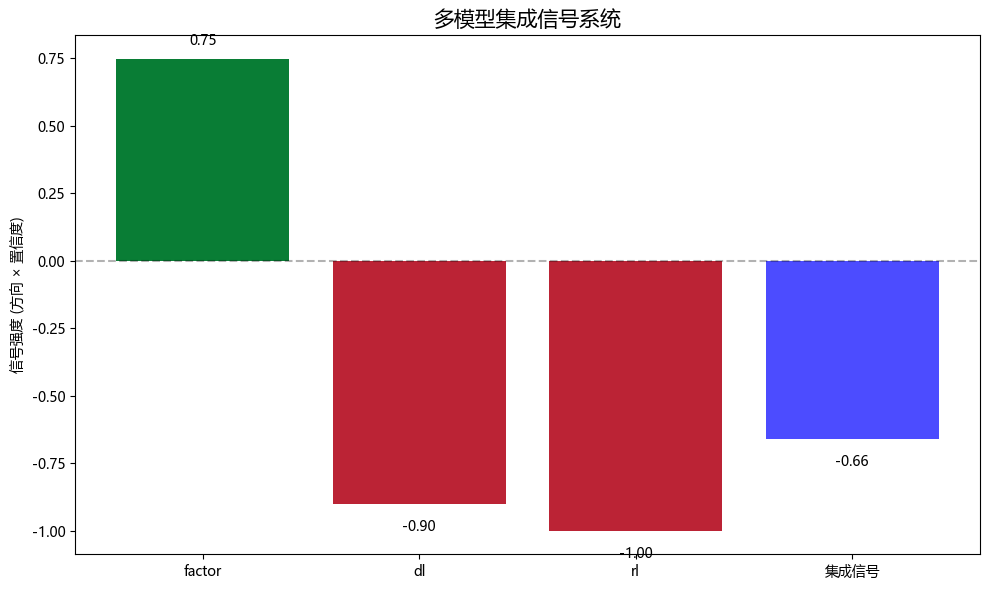

In [ ]:
def generate_ensemble_signal(price_data, use_deap=True, use_dl=True, use_rl=True):
    """生成集成信号"""
    if price_data is None or len(price_data) < 30:
        print("数据不足，无法生成集成信号")
        return None
        
    signals = {}
    confidence = {}
    
    # 获取因子信号
    if use_deap:
        try:
            factor_agent = FactorAgent()
            factor_agent.load_factors()  # 尝试加载已有因子
            factor_signals = factor_agent.generate_signals(price_data)
            signals['factor'] = factor_signals.get('signal', 'neutral')
            confidence['factor'] = factor_signals.get('confidence', 0.5)
            print(f"因子信号: {signals['factor']} (置信度: {confidence['factor']:.4f})")
        except Exception as e:
            print(f"获取因子信号时出错: {str(e)}")
    
    # 获取深度学习信号
    if use_dl:
        try:
            ml_agent = MLAgent(model_dir='models')
            ml_agent.load_models()  # 尝试加载已训练模型
            dl_signals = ml_agent.generate_signals(price_data)
            signals['dl'] = dl_signals.get('signal', 'neutral')
            confidence['dl'] = dl_signals.get('confidence', 0.5)
            print(f"深度学习信号: {signals['dl']} (置信度: {confidence['dl']:.4f})")
        except Exception as e:
            print(f"获取深度学习信号时出错: {str(e)}")
    
    # 获取强化学习信号
    if use_rl:
        try:
            rl_agent = RLTradingAgent(model_dir='models')
            rl_agent.load_model()  # 尝试加载已训练模型
            rl_signals = rl_agent.generate_signals(price_data)
            signals['rl'] = rl_signals.get('signal', 'neutral')
            confidence['rl'] = rl_signals.get('confidence', 0.5)
            print(f"强化学习信号: {signals['rl']} (置信度: {confidence['rl']:.4f})")
        except Exception as e:
            print(f"获取强化学习信号时出错: {str(e)}")
    
    # 生成加权集成信号
    if signals:
        # 定义各模型权重
        weights = {
            'factor': 0.3,
            'dl': 0.4,
            'rl': 0.3
        }
        
        # 初始化信号得分
        signal_scores = {
            'bullish': 0,
            'neutral': 0,
            'bearish': 0
        }
        
        # 累加加权得分
        for model, signal in signals.items():
            if signal in signal_scores and model in weights:
                model_weight = weights[model]
                model_confidence = confidence.get(model, 0.5)
                signal_scores[signal] += model_weight * model_confidence
        
        # 选择得分最高的信号
        ensemble_signal = max(signal_scores.items(), key=lambda x: x[1])[0]
        ensemble_confidence = max(signal_scores.values())
        
        print("\n集成信号系统结果:")
        print(f"最终信号: {ensemble_signal}")
        print(f"置信度: {ensemble_confidence:.4f}")
        
        # 可视化集成结果
        plt.figure(figsize=(10, 6))
        
        # 各模型信号得分
        models = list(signals.keys())
        signal_values = []
        
        # 将信号转换为数值
        signal_map = {'bearish': -1, 'neutral': 0, 'bullish': 1}
        for model in models:
            signal_value = signal_map.get(signals[model], 0) * confidence[model]
            signal_values.append(signal_value)
        
        # 绘制模型信号
        plt.bar(models, signal_values)
        
        # 添加颜色指示
        for i, val in enumerate(signal_values):
            color = 'green' if val > 0 else 'red' if val < 0 else 'gray'
            plt.bar(models[i], val, color=color, alpha=0.7)
        
        # 添加集成信号
        ensemble_value = signal_map.get(ensemble_signal, 0) * ensemble_confidence
        plt.bar('集成信号', ensemble_value, color='blue', alpha=0.7)
        
        plt.title('多模型集成信号系统', fontsize=15)
        plt.ylabel('信号强度 (方向 × 置信度)')
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        
        # 添加数值标签
        all_models = models + ['集成信号']
        all_values = signal_values + [ensemble_value]
        for i, v in enumerate(all_values):
            plt.text(i, v + (0.05 if v >= 0 else -0.1), f"{v:.2f}", ha='center')
        
        plt.tight_layout()
        plt.show()
        
        return {
            'signal': ensemble_signal,
            'confidence': ensemble_confidence,
            'model_signals': signals,
            'model_confidence': confidence
        }
    
    return None

# 生成集成信号
if price_data is not None and len(price_data) > 0:
    ensemble_results = generate_ensemble_signal(price_data)

### 6.2 完整投资决策流程与框架评估

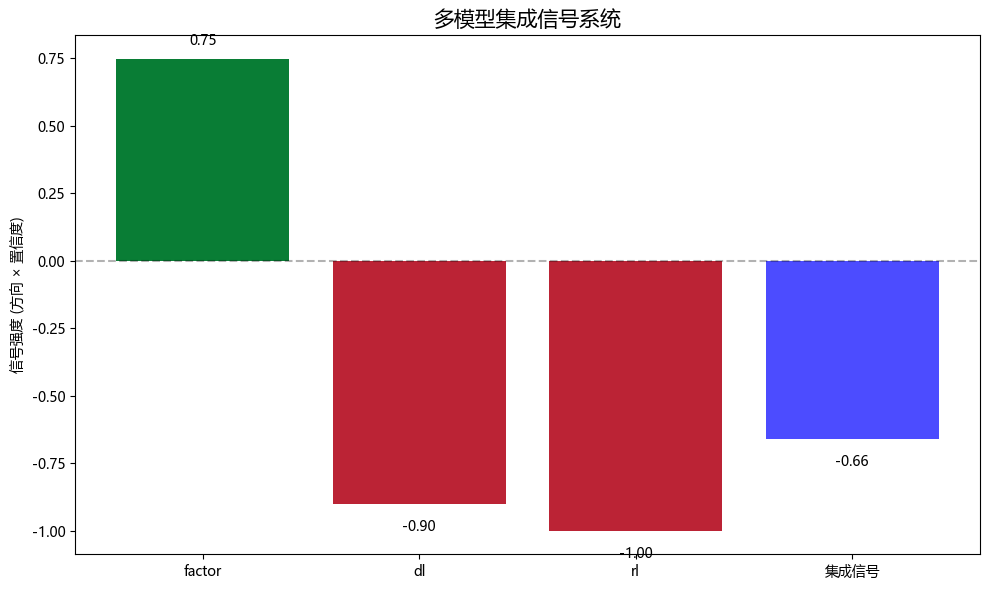

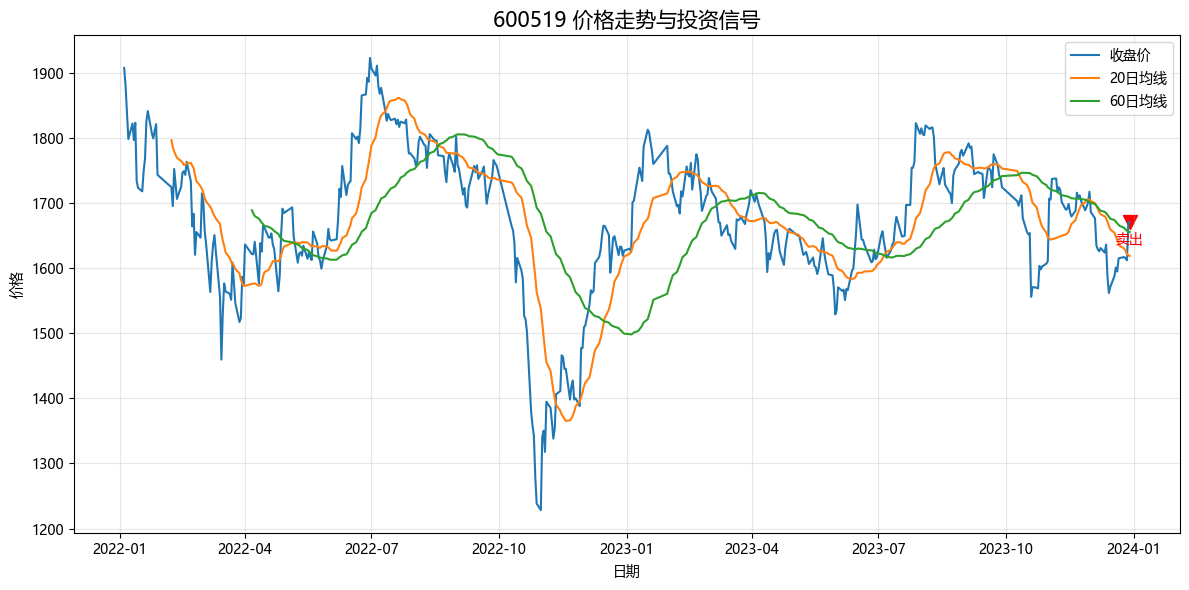

In [ ]:
def build_investment_decision_framework(ticker, start_date, end_date):
    """构建完整投资决策框架"""
    print(f"\n开始构建投资决策框架 - {ticker} ({start_date} to {end_date})")
    
    # 获取价格数据
    price_data = get_price_data(ticker, start_date, end_date)
    if price_data is None or len(price_data) == 0:
        print("无法获取价格数据")
        return None
    
    print(f"获取到{len(price_data)}条价格数据")
    
    # 1. 资产定价分析
    print("\n步骤 1: 资产定价分析")
    try:
        beta = calculate_beta(ticker, market_index="000300", start_date=start_date, end_date=end_date)
        print(f"股票Beta值: {beta:.4f}")
        
        # 获取市场收益率和无风险利率
        market_ret = get_market_returns(index_code="000300", start_date=start_date, end_date=end_date)
        risk_free = get_risk_free_rate(start_date=start_date, end_date=end_date)
        
        # 计算理论预期收益率 (CAPM)
        if market_ret is not None and risk_free is not None:
            market_premium = market_ret.mean() * 252 - risk_free.mean() * 252  # 年化市场风险溢价
            expected_return = risk_free.mean() * 252 + beta * market_premium  # 年化预期收益率
            print(f"CAPM理论预期年化收益率: {expected_return:.4f} ({expected_return*100:.2f}%)")
        else:
            expected_return = None
            print("无法获取市场风险溢价数据")
    except Exception as e:
        print(f"资产定价分析出错: {str(e)}")
        beta = None
        expected_return = None
    
    # 2. 趋势和技术分析
    print("\n步骤 2: 趋势和技术分析")
    # 计算移动平均线
    price_data['ma20'] = price_data['close'].rolling(window=20).mean()
    price_data['ma60'] = price_data['close'].rolling(window=60).mean()
    
    # 判断趋势
    current_price = price_data['close'].iloc[-1]
    ma20 = price_data['ma20'].iloc[-1]
    ma60 = price_data['ma60'].iloc[-1]
    
    if current_price > ma20 > ma60:
        trend = "上升趋势"
    elif current_price < ma20 < ma60:
        trend = "下降趋势"
    else:
        trend = "横盘整理"
    
    print(f"当前趋势: {trend}")
    print(f"收盘价 vs MA20: {(current_price/ma20 - 1)*100:.2f}%")
    print(f"MA20 vs MA60: {(ma20/ma60 - 1)*100:.2f}%")
    
    # 3. 波动率和风险分析
    print("\n步骤 3: 波动率和风险分析")
    # 计算历史波动率
    returns = price_data['close'].pct_change().dropna()
    annual_vol = returns.std() * np.sqrt(252)
    print(f"年化波动率: {annual_vol:.4f} ({annual_vol*100:.2f}%)")
    
    # 计算VaR
    try:
        var_95 = calculate_historical_var(returns, confidence_level=0.95)
        print(f"95% 历史VaR: {var_95*100:.4f}%")
    except Exception as e:
        print(f"计算VaR时出错: {str(e)}")
        var_95 = None
    
    # 4. 模型集成信号分析
    print("\n步骤 4: 模型集成信号分析")
    ensemble_signal = generate_ensemble_signal(price_data)
    
    # 5. 投资建议生成
    print("\n步骤 5: 投资建议生成")
    
    # 风险评估
    if annual_vol > 0.3:
        risk_level = "高"
    elif annual_vol > 0.2:
        risk_level = "中高"
    elif annual_vol > 0.1:
        risk_level = "中"
    else:
        risk_level = "低"
    
    # 生成投资建议
    if ensemble_signal and 'signal' in ensemble_signal:
        signal = ensemble_signal['signal']
        confidence = ensemble_signal['confidence']
        
        if signal == 'bullish' and confidence > 0.6:
            action = "买入"
            reason = f"模型给出强烈看多信号 (置信度: {confidence:.2f})，且股票处于{trend}"
        elif signal == 'bullish' and confidence > 0.3:
            action = "增持"
            reason = f"模型给出看多信号 (置信度: {confidence:.2f})"
        elif signal == 'bearish' and confidence > 0.6:
            action = "卖出"
            reason = f"模型给出强烈看空信号 (置信度: {confidence:.2f})，且股票处于{trend}"
        elif signal == 'bearish' and confidence > 0.3:
            action = "减持"
            reason = f"模型给出看空信号 (置信度: {confidence:.2f})"
        else:
            action = "观望"
            reason = f"模型信号不明确 (置信度不足)"
    else:
        action = "观望"
        reason = "无法获取模型信号"
    
    # 风险提示
    risk_warning = f"风险等级: {risk_level}"
    if var_95 is not None:
        risk_warning += f"。日亏损可能超过{var_95*100:.2f}%的概率为5%。"
    
    # 打印投资建议
    print("\n---------- 投资建议 ----------")
    print(f"股票: {ticker}")
    print(f"建议操作: {action}")
    print(f"理由: {reason}")
    print(f"风险提示: {risk_warning}")
    if expected_return is not None:
        print(f"预期年化收益率: {expected_return*100:.2f}%")
    print("--------------------------------")
    
    # 可视化价格走势和信号
    plt.figure(figsize=(12, 6))
    
    # 绘制价格和均线
    plt.plot(price_data['date'], price_data['close'], label='收盘价')
    plt.plot(price_data['date'], price_data['ma20'], label='20日均线')
    plt.plot(price_data['date'], price_data['ma60'], label='60日均线')
    
    # 添加信号标记
    last_date = price_data['date'].iloc[-1]
    
    if action == "买入" or action == "增持":
        plt.scatter(last_date, current_price, color='green', s=100, marker='^')
        plt.text(last_date, current_price*1.02, action, color='green', ha='center')
    elif action == "卖出" or action == "减持":
        plt.scatter(last_date, current_price, color='red', s=100, marker='v')
        plt.text(last_date, current_price*0.98, action, color='red', ha='center')
    
    plt.title(f'{ticker} 价格走势与投资信号', fontsize=15)
    plt.xlabel('日期')
    plt.ylabel('价格')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return {
        'ticker': ticker,
        'action': action,
        'reason': reason,
        'risk_level': risk_level,
        'expected_return': expected_return,
        'var_95': var_95,
        'beta': beta,
        'annual_vol': annual_vol,
        'trend': trend,
        'signal': ensemble_signal
    }

# 运行投资决策框架
decision = build_investment_decision_framework('600519', '2022-01-01', '2023-12-31')

### 7.1 模型性能比较

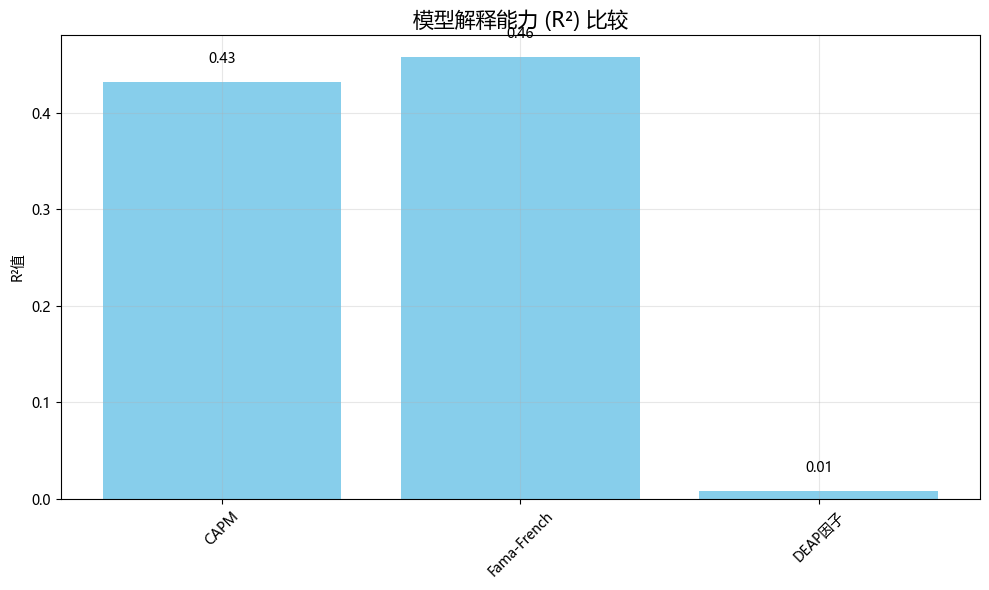

In [ ]:
def compare_models_performance():
    """比较不同模型的性能"""
    # 检查全局变量中是否有模型结果
    has_capm_results = 'capm_results_all' in globals() and capm_results_all
    has_ff_results = 'ff_results_all' in globals() and ff_results_all
    
    if not has_capm_results and not has_ff_results:
        print("没有足够的模型结果数据进行比较")
        return None
    
    # 各模型的R²
    r_squared = {}
    
    if has_capm_results:
        r_squared['CAPM'] = np.mean([result['r_squared'] for result in capm_results_all.values()])
    
    if has_ff_results:
        valid_ff_results = [result for result in ff_results_all.values() if result is not None]
        if valid_ff_results:
            r_squared['Fama-French'] = np.mean([result['r_squared'] for result in valid_ff_results])
    
    # 如果有LSTM结果
    if 'signals' in globals() and signals and 'lstm_predictions' in signals:
        # 这里应该从signals中提取LSTM的R²，如果有的话
        # 例如: r_squared['LSTM'] = signals.get('lstm_r_squared', 0)
        pass
    
    # 如果有因子结果
    if 'factor_significance' in globals() and factor_significance:
        r_squared['DEAP因子'] = factor_significance.get('model_stats', {}).get('R-squared', 0)
    
    # 绘制可用的模型比较
    if r_squared:
        plt.figure(figsize=(10, 6))
        models = list(r_squared.keys())
        values = list(r_squared.values())
        
        plt.bar(models, values, color='skyblue')
        plt.title('模型解释能力 (R²) 比较', fontsize=15)
        plt.ylabel('R²值')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # 为每个柱添加数值标签
        for i, v in enumerate(values):
            plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
        
        plt.tight_layout()
        plt.show()
    
    return r_squared

# 比较模型性能
model_performance = compare_models_performance()

### 7.2 样本外测试与交叉验证

In [ ]:
def perform_out_of_sample_test(price_data):
    """进行样本外测试以避免过拟合"""
    if price_data is None or len(price_data) < 60:
        print("数据不足，无法进行样本外测试")
        return None
    
    # 划分训练集和测试集
    train_size = int(len(price_data) * 0.7)
    train_data = price_data.iloc[:train_size]
    test_data = price_data.iloc[train_size:]
    
    print(f"训练集大小: {len(train_data)}行, 时间段: {train_data.index[0]} 至 {train_data.index[-1]}")
    print(f"测试集大小: {len(test_data)}行, 时间段: {test_data.index[0]} 至 {test_data.index[-1]}")
    
    # 使用MLAgent进行实际模型训练和评估
    try:
        # 初始化模型
        ml_agent = MLAgent(model_dir='models')
        
        # 在训练集上训练模型
        print("在训练集上训练模型...")
        ml_agent.train_models(train_data)
        
        # 在测试集上生成预测
        print("在测试集上生成预测...")
        test_signals = ml_agent.generate_signals(test_data)
        
        # 评估模型性能
        print("\n测试集性能评估:")
        if 'signal' in test_signals:
            print(f"综合信号: {test_signals['signal']}")
            print(f"置信度: {test_signals.get('confidence', 0):.4f}")
        
        if 'lstm_predictions' in test_signals:
            lstm_predictions = test_signals['lstm_predictions']
            
            # 如果有预期收益率，计算与实际收益的相关性
            if 'expected_returns' in lstm_predictions:
                expected_returns = lstm_predictions['expected_returns']
                
                # 计算测试集的实际收益率
                actual_returns = test_data['close'].pct_change().dropna()
                
                # 确保长度匹配
                min_length = min(len(expected_returns), len(actual_returns))
                if min_length > 0:
                    expected_returns = expected_returns[:min_length]
                    actual_returns = actual_returns.iloc[:min_length].values
                    
                    # 计算相关性
                    correlation, p_value = stats.pearsonr(expected_returns, actual_returns)
                    print(f"预测收益与实际收益相关系数: {correlation:.4f} (p值: {p_value:.4f})")
                    
                    # 计算方向准确率
                    direction_accuracy = np.mean((np.array(expected_returns) > 0) == (actual_returns > 0))
                    print(f"方向预测准确率: {direction_accuracy:.4f}")
                    
                    # 计算均方根误差
                    rmse = np.sqrt(np.mean((np.array(expected_returns) - actual_returns) ** 2))
                    print(f"均方根误差 (RMSE): {rmse:.6f}")
                    
                    # 可视化预测与实际收益对比
                    plt.figure(figsize=(12, 6))
                    plt.plot(range(min_length), actual_returns, label='实际收益率')
                    plt.plot(range(min_length), expected_returns, label='预测收益率', linestyle='--')
                    plt.title('测试集上的预测收益率 vs 实际收益率', fontsize=15)
                    plt.xlabel('时间')
                    plt.ylabel('收益率')
                    plt.legend()
                    plt.grid(True, alpha=0.3)
                    plt.tight_layout()
                    plt.show()
                    
                    # 返回模型性能指标
                    return {
                        'train_data': train_data,
                        'test_data': test_data,
                        'correlation': correlation,
                        'p_value': p_value,
                        'direction_accuracy': direction_accuracy,
                        'rmse': rmse,
                        'predicted_returns': expected_returns,
                        'actual_returns': actual_returns
                    }
                else:
                    print("预测收益率和实际收益率没有足够的重叠数据点进行分析")
            else:
                print("LSTM预测中没有预期收益率信息")
        else:
            print("测试结果中没有LSTM预测")
            
        # 即使没有详细的预测数据，也返回基本的训练/测试数据划分
        return {
            'train_data': train_data,
            'test_data': test_data
        }
    except Exception as e:
        print(f"样本外测试过程中出错: {str(e)}")
        import traceback
        traceback.print_exc()
        
        # 出错时也返回数据划分
        return {
            'train_data': train_data,
            'test_data': test_data
        }


In [ ]:
# 进行k折交叉验证
def perform_cross_validation(price_data, k=5):
    """对模型进行k折交叉验证"""
    if price_data is None or len(price_data) < 50:
        print("数据不足，无法进行交叉验证")
        return None
        
    try:
        # 创建k个折叠
        fold_size = len(price_data) // k
        results = []
        
        print(f"\n进行{k}折交叉验证:")
        
        for i in range(k):
            print(f"\n第{i+1}折验证:")
            
            # 计算当前折叠的起始和结束索引
            start_idx = i * fold_size
            end_idx = (i + 1) * fold_size if i < k - 1 else len(price_data)
            
            # 划分训练集和验证集
            val_data = price_data.iloc[start_idx:end_idx]
            train_data = pd.concat([price_data.iloc[:start_idx], price_data.iloc[end_idx:]])
            
            print(f"训练集大小: {len(train_data)}行")
            print(f"验证集大小: {len(val_data)}行")
            
            # 初始化模型
            ml_agent = MLAgent(model_dir=f'models/models_fold_{i}')
            
            # 训练模型
            print("训练模型...")
            ml_agent.train_models(train_data)
            
            # 在验证集上评估
            print("在验证集上评估...")
            val_signals = ml_agent.generate_signals(val_data)
            
            # 收集性能指标
            fold_result = {
                'fold': i + 1,
                'signal': val_signals.get('signal', 'unknown'),
                'confidence': val_signals.get('confidence', 0)
            }
            
            # 如果有LSTM预测，评估其准确性
            if 'lstm_predictions' in val_signals and 'expected_returns' in val_signals['lstm_predictions']:
                expected_returns = val_signals['lstm_predictions']['expected_returns']
                actual_returns = val_data['close'].pct_change().dropna()
                
                # 确保长度匹配
                min_length = min(len(expected_returns), len(actual_returns))
                if min_length > 0:
                    # 截取相同长度的数据
                    expected_returns = expected_returns[:min_length]
                    actual_returns = actual_returns.iloc[:min_length].values
                    
                    # 计算相关性
                    correlation, p_value = stats.pearsonr(expected_returns, actual_returns)
                    fold_result['correlation'] = correlation
                    fold_result['p_value'] = p_value
                    
                    # 计算方向准确率
                    direction_accuracy = np.mean((np.array(expected_returns) > 0) == (actual_returns > 0))
                    fold_result['direction_accuracy'] = direction_accuracy
                    
                    # 计算均方根误差
                    rmse = np.sqrt(np.mean((np.array(expected_returns) - actual_returns) ** 2))
                    fold_result['rmse'] = rmse
                    
                    print(f"验证集相关系数: {correlation:.4f}")
                    print(f"验证集方向准确率: {direction_accuracy:.4f}")
                    print(f"验证集RMSE: {rmse:.6f}")
            
            results.append(fold_result)
        
        # 汇总结果
        if results:
            print("\n交叉验证汇总结果:")
            
            # 提取需要汇总的指标
            metrics = ['correlation', 'direction_accuracy', 'rmse']
            summary = {}
            
            for metric in metrics:
                values = [r[metric] for r in results if metric in r]
                if values:
                    summary[f'mean_{metric}'] = np.mean(values)
                    summary[f'std_{metric}'] = np.std(values)
                    print(f"平均{metric}: {np.mean(values):.4f} ± {np.std(values):.4f}")
            
            # 可视化交叉验证结果
            plt.figure(figsize=(12, 5))
            
            # 绘制方向准确率
            direction_values = [r.get('direction_accuracy', 0) for r in results]
            plt.subplot(1, 2, 1)
            plt.bar(range(1, k+1), direction_values)
            plt.axhline(y=np.mean(direction_values), color='r', linestyle='--', 
                       label=f'平均值: {np.mean(direction_values):.4f}')
            plt.title('各折叠的方向准确率', fontsize=15)
            plt.xlabel('折叠')
            plt.ylabel('方向准确率')
            plt.xticks(range(1, k+1))
            plt.ylim(0, 1)
            plt.legend()
            
            # 绘制相关系数
            corr_values = [r.get('correlation', 0) for r in results]
            plt.subplot(1, 2, 2)
            plt.bar(range(1, k+1), corr_values)
            plt.axhline(y=np.mean(corr_values), color='r', linestyle='--',
                       label=f'平均值: {np.mean(corr_values):.4f}')
            plt.title('各折叠的相关系数', fontsize=15)
            plt.xlabel('折叠')
            plt.ylabel('相关系数')
            plt.xticks(range(1, k+1))
            plt.legend()
            
            plt.tight_layout()
            plt.show()
            
            return {
                'folds': results,
                'summary': summary
            }
        else:
            print("交叉验证没有产生有效结果")
            return None
    except Exception as e:
        print(f"交叉验证过程中出错: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

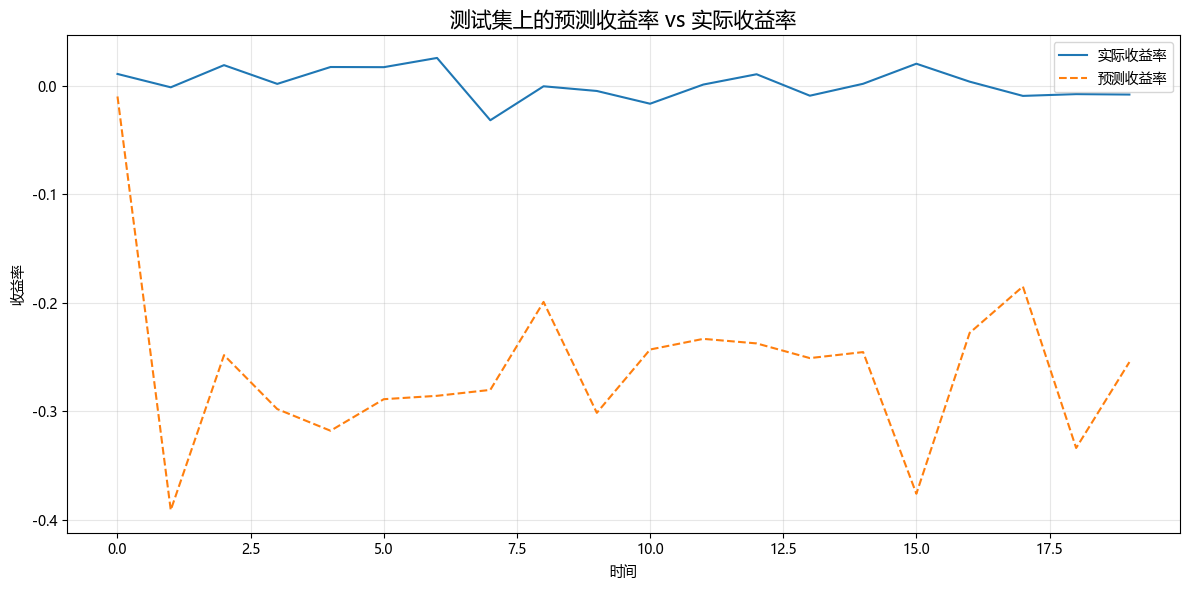

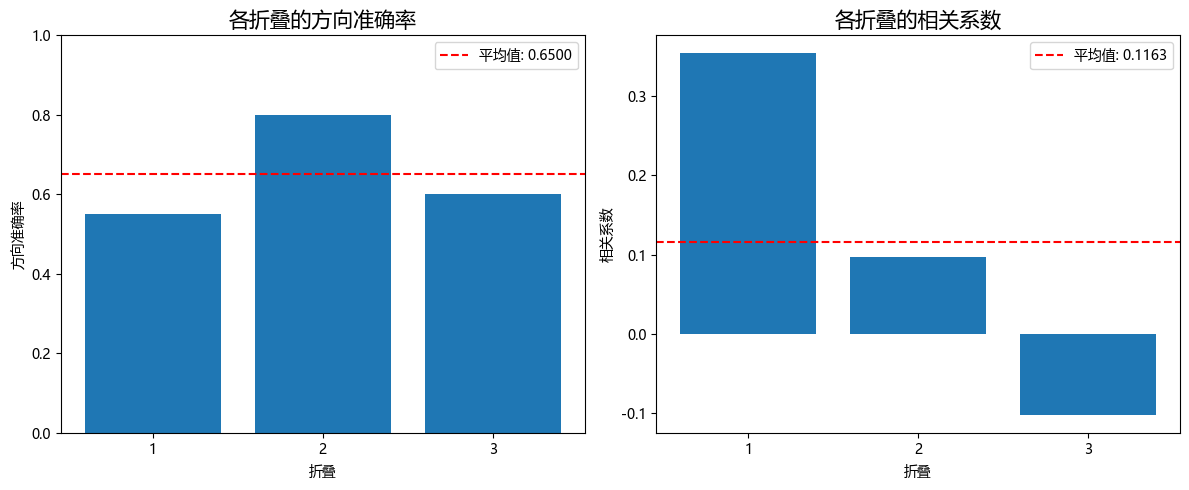

In [ ]:
# 如果有价格数据，进行样本外测试
if 'processed_data' in globals() and isinstance(processed_data, pd.DataFrame) and not processed_data.empty:
    print("\n执行样本外测试...")
    out_of_sample_results = perform_out_of_sample_test(processed_data)
    
    # 可选: 进行交叉验证
    if len(processed_data) >= 100:  # 确保有足够的数据进行交叉验证
        print("\n执行交叉验证...")
        cv_results = perform_cross_validation(processed_data, k=3)  # 使用较小的k以减少计算量

### 7.3 稳健性检验与多重检验调整

In [ ]:
def adjust_multiple_testing(p_values):
    """进行多重检验校正"""
    if not p_values or len(p_values) == 0:
        print("没有p值，无法进行多重检验调整")
        return None
    
    import statsmodels.stats.multitest as mt
    
    # 使用Benjamini-Hochberg程序控制错误发现率(FDR)
    rejected, adjusted_p_values, _, _ = mt.multipletests(p_values, alpha=0.05, method='fdr_bh')
    
    # 打印结果
    print("\n多重检验调整结果:")
    for i, (original_p, adjusted_p, rej) in enumerate(zip(p_values, adjusted_p_values, rejected)):
        significance = "显著" if rej else "不显著"
        print(f"检验{i+1}: 原始p值 = {original_p:.4f}, 调整后p值 = {adjusted_p:.4f}, {significance}")
    
    return {
        'rejected': rejected,  # 哪些原假设被拒绝
        'adjusted_p_values': adjusted_p_values  # 调整后的p值
    }

In [ ]:
# 如果我们有CAPM模型的p值，进行多重检验调整
if 'capm_significance' in globals() and capm_significance:
    p_values_alpha = [result.get('p_value_alpha', 1.0) for result in capm_results_all.values() if 'p_value_alpha' in result]
    
    if p_values_alpha:
        print("\n对CAPM Alpha的p值进行多重检验调整:")
        adjusted_alpha_results = adjust_multiple_testing(p_values_alpha)

In [ ]:
adjusted_alpha_results

{'rejected': array([False, False, False, False, False]),
 'adjusted_p_values': array([0.76836405, 0.97209961, 0.76836405, 0.76836405, 0.76836405])}